## <프로젝트 유형: Multi-Step LSTM Time Series Forecasting>
* windows개념 이용해서 univariate time series forecasting의 방법으로 해결해보고자 함

In [2]:
# Runned_by_Colab

# 1. 이번 Trial 내용
# ReduceLROnPlateau() <- loss값에 따라 학습률 자동으로 조정해주는 매서드
# 각 sample_id마다 test_x데이터로 학습할 때, 학습 이후 줄어든 최종 loss값과 learning rate 그리고 sample_id 출력하도록 설정
# input: 60, output: 1의 many-to-one 모델

---

In [3]:
#Import Library
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Dropout, Bidirectional#,Reshape, Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Read Data
data_path = '../Big_Data/[DACON]Bit_Trader'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

In [5]:
# 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

# 2차원 DF LSTM으로 학습하기 위해 3차원으로 변환시키기
train_x_array = df2d_to_array3d(train_x_df)   #(1380, 1380, 10)
train_y_array = df2d_to_array3d(train_y_df)   #(1380, 120, 10)
test_x_array = df2d_to_array3d(test_x_df)     #(529, 1380, 10)

In [6]:
# 모델 구성(op1: many-to-one model, op2: many-to-many model(output 모양 바꾸기, return_sequences = True, Window이동 단위 1에서 output 크기로 변경))
# LSTM에 return_sequence=True가 주어지고 Bidirectional이면서 TimeDistributed() 함수가 사용되면 양방향 many-to-many 유형이 된다.https://m.blog.naver.com/chunjein/221589656211
# TimeDistributed() 함수 사용: 모델 layer에 model.add(TimeDistributed(Dense(1, activation='sigmoid')))추가

def build_model():
    seq_len = 60
    model = Sequential()
    # 첫 번째 layer에서 LSTM()매서드 안의 stateful = True는 오히려 다운 퍼포먼스 될 수 있음
    model.add(LSTM(50, activation='tanh', return_sequences= True, input_shape = [seq_len, 1], dropout = 0.2)) 
#     model.add(Bidirectional(LSTM(50, activation='tanh', dropout=0.50, recurrent_dropout=0.25)))
    model.add(LSTM(50, activation= 'tanh', dropout = 0.2))
    model.add(Dense(1))  #60개의 open값 입력되어 121번째 open값 '하나' 예측   
    
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
    
    return model

In [7]:
build_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [8]:
# LearningRateScheduler(scheduler) 구현

# from tensorflow.keras.callbacks import LearningRateScheduler
# # LearningRateScheduler 함수 생성 (epoch이 5이하면 그대로 lr 유지, 아닐시 lr 조정)
# def scheduler(epoch, learning_rate):
#     if epoch < 5:
#         return learning_rate
#     else:
#         return learning_rate * tf.math.exp(-0.1)
# lr = LearningRateScheduler(scheduler)

In [9]:
# test_x_array에 대한 Auto_Regressive한 Prediction 및 valid_pred_array에 예측 결과 기록

# 1) test_pred_array{예측값 모아두는 3차원 배열(120*1 2차원 배열 529개)} 만들기
test_pred_array = np.zeros([len(test_x_array), 120, 1])

# 2) early_stoppage & reduceLR 정의: https://www.dacon.io/competitions/official/235709/codeshare/2453?page=1&dtype=recent 참고)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 10, mode = 'auto')
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience= 5, min_lr=0)

# 3) test_x_array로 시계열 Windows 만들기 -> 데이터셋 구성 -> 모델 학습 ||| 예측 -> test_pred_array에 기록 -> window_3d의 첫번째 값 삭제 -> test_pred_array와 window_3d 병합 -> model.predict()에 넣어 예측 -> ***
ep = 30
bs = 120
# idx에 해당하는 샘플 529개 학습: for loop 529번 돌아감
for idx in tqdm(range(test_x_array.shape[0])):  # 529번
    seq_len = 60
    sequence_length = seq_len + 1

    windows = []
    for index in range(1380 - sequence_length):
        windows.append(test_x_array[idx, :, 1][index: index + sequence_length])

    # x_test, y_test 데이터셋 구성
    windows = np.array(windows)  # 1329 * 121의 2차원 배열
    x_test = windows[:, :-1]
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    y_test = windows[:, -1]
    
    model = build_model()
    history = model.fit(x_test, y_test, epochs= ep, batch_size= bs, verbose=0, shuffle = True, callbacks=[early_stop, reduceLR])
# shuffle= True 효과 있을까? 미약하게나마 효과 있음. https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
    print('sample_id : ', idx, '번')
    print('loss : ', history.history['loss'][-1])
#     print('mse : ', history.history['mse'][-1])  #<- model.compile()의 metrics인자값으로 설정된 값을 추가로 출력해 주고 싶다면!
    print('lr : ', round(model.optimizer.lr.numpy(), 5))  #<-조정된 학습률 출력

    # test_x_array Windows 중 마지막 윈도우 추출해서 3차원 변환시켜 LSTM모델에 넣고 Predict
    window = windows[-1, :-1]  # windows.shape (1259, 61), window.shape (60, )
    window_3d = np.reshape(window, (1, window.shape[0], 1))  # (1, 60, 1)
    for m in range(120):
        # model.predict()에 window_3d 넣어 예측
        pred = model.predict(window_3d)

        # 120분 중 처음 1분 예측값 test_pred_array에 기록
        test_pred_array[idx, m, :] = pred

        # window_3d의 첫번째 분 값을 삭제한 window_3d_2nd 구성
        window_3d_2nd = window_3d[0, 1:, :]  # 119개 -> 118개 -> ***

        # pred_target(prediction할 때마다 나오는 각각의 예측값들) 1차원 -> 2차원으로 구성
        pred_target = test_pred_array[idx, m, :]
        pred_target = np.reshape(pred_target, (pred_target.shape[0], 1))

        # test_pred_array와 window_3d_2nd 병합하여 모델에 입력할 새로운 window_3d 재구성
        window_3d = np.concatenate((window_3d_2nd, pred_target), axis=0)
        window_3d = window_3d.T
        window_3d = np.reshape(window_3d, (window_3d.shape[0], window_3d.shape[1], 1))   

  0%|          | 0/529 [00:00<?, ?it/s]

sample_id :  0 번
loss :  0.0003583619254641235
lr :  0.001


  0%|          | 1/529 [00:11<1:39:03, 11.26s/it]

sample_id :  1 번
loss :  0.00019927765242755413
lr :  0.001


  0%|          | 2/529 [00:20<1:33:32, 10.65s/it]

sample_id :  2 번
loss :  0.004331523086875677
lr :  1e-05


  1%|          | 3/529 [00:29<1:29:34, 10.22s/it]

sample_id :  3 번
loss :  0.0019436110742390156
lr :  1e-04


  1%|          | 4/529 [00:39<1:27:20,  9.98s/it]

sample_id :  4 번
loss :  0.00020016686175949872
lr :  1e-04


  1%|          | 5/529 [00:48<1:25:30,  9.79s/it]

sample_id :  5 번
loss :  0.0011961252894252539
lr :  1e-05


  1%|          | 6/529 [00:57<1:23:59,  9.63s/it]

sample_id :  6 번
loss :  0.0007870410336181521
lr :  1e-04


  1%|▏         | 7/529 [01:07<1:23:06,  9.55s/it]

sample_id :  7 번
loss :  0.0013207155279815197
lr :  0.001


  2%|▏         | 8/529 [01:16<1:22:14,  9.47s/it]

sample_id :  8 번
loss :  0.0008721580961719155
lr :  0.001


  2%|▏         | 9/529 [01:25<1:22:00,  9.46s/it]

sample_id :  9 번
loss :  0.0016306438483297825
lr :  1e-04


  2%|▏         | 10/529 [01:35<1:21:34,  9.43s/it]

sample_id :  10 번
loss :  0.0003049788356292993
lr :  1e-04


  2%|▏         | 11/529 [01:44<1:20:15,  9.30s/it]

sample_id :  11 번
loss :  0.0012082356261089444
lr :  0.001


  2%|▏         | 12/529 [01:53<1:20:19,  9.32s/it]

sample_id :  12 번
loss :  0.00016751706425566226
lr :  1e-04


  2%|▏         | 13/529 [02:03<1:20:36,  9.37s/it]

sample_id :  13 번
loss :  0.0005567019688896835
lr :  0.001


  3%|▎         | 14/529 [02:12<1:20:05,  9.33s/it]

sample_id :  14 번
loss :  0.0008115307427942753
lr :  1e-04


  3%|▎         | 15/529 [02:21<1:20:11,  9.36s/it]

sample_id :  15 번
loss :  0.0006544224452227354
lr :  0.001


  3%|▎         | 16/529 [02:31<1:20:13,  9.38s/it]

sample_id :  16 번
loss :  0.0002908618189394474
lr :  1e-04


  3%|▎         | 17/529 [02:40<1:20:08,  9.39s/it]

sample_id :  17 번
loss :  0.0023063914850354195
lr :  1e-04


  3%|▎         | 18/529 [02:50<1:20:13,  9.42s/it]

sample_id :  18 번
loss :  0.0007136696949601173
lr :  0.001


  4%|▎         | 19/529 [02:59<1:19:51,  9.40s/it]

sample_id :  19 번
loss :  0.0015415367670357227
lr :  1e-05


  4%|▍         | 20/529 [03:08<1:19:39,  9.39s/it]

sample_id :  20 번
loss :  0.0010653672507032752
lr :  1e-04


  4%|▍         | 21/529 [03:18<1:19:25,  9.38s/it]

sample_id :  21 번
loss :  0.002351547824218869
lr :  1e-04


  4%|▍         | 22/529 [03:27<1:19:13,  9.38s/it]

sample_id :  22 번
loss :  0.0005000660894438624
lr :  0.001


  4%|▍         | 23/529 [03:36<1:19:11,  9.39s/it]

sample_id :  23 번
loss :  0.0028697906527668238
lr :  1e-04


  5%|▍         | 24/529 [03:46<1:19:27,  9.44s/it]

sample_id :  24 번
loss :  0.0005430775927379727
lr :  0.001


  5%|▍         | 25/529 [03:56<1:19:46,  9.50s/it]

sample_id :  25 번
loss :  0.0028256054501980543
lr :  1e-04


  5%|▍         | 26/529 [04:05<1:20:21,  9.59s/it]

sample_id :  26 번
loss :  0.002060480182990432
lr :  1e-04


  5%|▌         | 27/529 [04:15<1:20:04,  9.57s/it]

sample_id :  27 번
loss :  0.0012269187718629837
lr :  0.001


  5%|▌         | 28/529 [04:25<1:20:00,  9.58s/it]

sample_id :  28 번
loss :  0.002752474742010236
lr :  1e-04


  5%|▌         | 29/529 [04:34<1:19:53,  9.59s/it]

sample_id :  29 번
loss :  0.0006919411243870854
lr :  0.001


  6%|▌         | 30/529 [04:44<1:19:20,  9.54s/it]

sample_id :  30 번
loss :  0.0003424878232181072
lr :  1e-04


  6%|▌         | 31/529 [04:53<1:18:11,  9.42s/it]

sample_id :  31 번
loss :  0.0002722902281675488
lr :  0.001


  6%|▌         | 32/529 [05:02<1:18:12,  9.44s/it]

sample_id :  32 번
loss :  0.0011245361529290676
lr :  0.001


  6%|▌         | 33/529 [05:12<1:18:16,  9.47s/it]

sample_id :  33 번
loss :  0.0011235958663746715
lr :  1e-04


  6%|▋         | 34/529 [05:21<1:18:20,  9.50s/it]

sample_id :  34 번
loss :  0.00048068634350784123
lr :  1e-04


  7%|▋         | 35/529 [05:31<1:18:02,  9.48s/it]

sample_id :  35 번
loss :  0.0022227170411497355
lr :  1e-05


  7%|▋         | 36/529 [05:40<1:17:47,  9.47s/it]

sample_id :  36 번
loss :  0.001030949060805142
lr :  0.001


  7%|▋         | 37/529 [05:50<1:17:53,  9.50s/it]

sample_id :  37 번
loss :  0.0016263825818896294
lr :  1e-05


  7%|▋         | 38/529 [05:59<1:17:28,  9.47s/it]

sample_id :  38 번
loss :  0.0005277891177684069
lr :  1e-05


  7%|▋         | 39/529 [06:09<1:17:18,  9.47s/it]

sample_id :  39 번
loss :  0.00046837018453516066
lr :  0.001


  8%|▊         | 40/529 [06:18<1:17:05,  9.46s/it]

sample_id :  40 번
loss :  0.0009080498712137341
lr :  1e-05


  8%|▊         | 41/529 [06:28<1:16:58,  9.46s/it]

sample_id :  41 번
loss :  0.0004955937620252371
lr :  1e-04


  8%|▊         | 42/529 [06:37<1:16:41,  9.45s/it]

sample_id :  42 번
loss :  0.0004126260173507035
lr :  1e-04


  8%|▊         | 43/529 [06:46<1:16:29,  9.44s/it]

sample_id :  43 번
loss :  0.0004647521418519318
lr :  0.001


  8%|▊         | 44/529 [06:56<1:16:13,  9.43s/it]

sample_id :  44 번
loss :  0.0037153635639697313
lr :  1e-05


  9%|▊         | 45/529 [07:05<1:16:15,  9.45s/it]

sample_id :  45 번
loss :  0.0002857694635167718
lr :  1e-04


  9%|▊         | 46/529 [07:15<1:16:08,  9.46s/it]

sample_id :  46 번
loss :  0.0005810834118165076
lr :  1e-04


  9%|▉         | 47/529 [07:24<1:16:05,  9.47s/it]

sample_id :  47 번
loss :  0.0002677254960872233
lr :  1e-04


  9%|▉         | 48/529 [07:34<1:16:03,  9.49s/it]

sample_id :  48 번
loss :  0.000604021071922034
lr :  1e-04


  9%|▉         | 49/529 [07:43<1:15:48,  9.48s/it]

sample_id :  49 번
loss :  0.0008007543510757387
lr :  1e-04


  9%|▉         | 50/529 [07:53<1:15:48,  9.50s/it]

sample_id :  50 번
loss :  0.0013075702590867877
lr :  1e-04


 10%|▉         | 51/529 [08:02<1:15:47,  9.51s/it]

sample_id :  51 번
loss :  0.0006711228634230793
lr :  1e-05


 10%|▉         | 52/529 [08:12<1:15:39,  9.52s/it]

sample_id :  52 번
loss :  0.0002316891768714413
lr :  0.001


 10%|█         | 53/529 [08:21<1:14:39,  9.41s/it]

sample_id :  53 번
loss :  0.0005084272706881166
lr :  1e-04


 10%|█         | 54/529 [08:30<1:14:40,  9.43s/it]

sample_id :  54 번
loss :  0.0007866260129958391
lr :  1e-04


 10%|█         | 55/529 [08:40<1:14:38,  9.45s/it]

sample_id :  55 번
loss :  0.0007601210963912308
lr :  0.001


 11%|█         | 56/529 [08:50<1:15:00,  9.51s/it]

sample_id :  56 번
loss :  0.0012635511811822653
lr :  1e-04


 11%|█         | 57/529 [08:59<1:14:54,  9.52s/it]

sample_id :  57 번
loss :  0.0005540181882679462
lr :  1e-04


 11%|█         | 58/529 [09:09<1:15:42,  9.64s/it]

sample_id :  58 번
loss :  0.0005419010412879288
lr :  1e-04


 11%|█         | 59/529 [09:19<1:16:33,  9.77s/it]

sample_id :  59 번
loss :  0.00043686991557478905
lr :  0.001


 11%|█▏        | 60/529 [09:29<1:17:00,  9.85s/it]

sample_id :  60 번
loss :  0.004270164296030998
lr :  1e-05


 12%|█▏        | 61/529 [09:39<1:17:44,  9.97s/it]

sample_id :  61 번
loss :  0.001052701729349792
lr :  1e-04


 12%|█▏        | 62/529 [09:49<1:17:46,  9.99s/it]

sample_id :  62 번
loss :  0.001215983647853136
lr :  1e-05


 12%|█▏        | 63/529 [09:59<1:17:07,  9.93s/it]

sample_id :  63 번
loss :  0.002817373024299741
lr :  1e-04


 12%|█▏        | 64/529 [10:09<1:16:41,  9.90s/it]

sample_id :  64 번
loss :  0.0012864393647760153
lr :  1e-04


 12%|█▏        | 65/529 [10:19<1:16:09,  9.85s/it]

sample_id :  65 번
loss :  0.006016809958964586
lr :  0.0


 12%|█▏        | 66/529 [10:28<1:15:13,  9.75s/it]

sample_id :  66 번
loss :  0.0005127054755575955
lr :  1e-05


 13%|█▎        | 67/529 [10:38<1:15:08,  9.76s/it]

sample_id :  67 번
loss :  0.0008330626878887415
lr :  1e-05


 13%|█▎        | 68/529 [10:48<1:14:48,  9.74s/it]

sample_id :  68 번
loss :  0.0041312663815915585
lr :  1e-04


 13%|█▎        | 69/529 [10:58<1:15:09,  9.80s/it]

sample_id :  69 번
loss :  0.0006457447307184339
lr :  1e-04


 13%|█▎        | 70/529 [11:08<1:15:22,  9.85s/it]

sample_id :  70 번
loss :  0.00022093381267040968
lr :  1e-04


 13%|█▎        | 71/529 [11:17<1:14:14,  9.73s/it]

sample_id :  71 번
loss :  0.000940333295147866
lr :  1e-04


 14%|█▎        | 72/529 [11:27<1:14:11,  9.74s/it]

sample_id :  72 번
loss :  0.0009348847088404
lr :  1e-04


 14%|█▍        | 73/529 [11:37<1:14:16,  9.77s/it]

sample_id :  73 번
loss :  0.0008138903649523854
lr :  0.001


 14%|█▍        | 74/529 [11:47<1:14:19,  9.80s/it]

sample_id :  74 번
loss :  0.0005486628506332636
lr :  1e-04


 14%|█▍        | 75/529 [11:56<1:14:12,  9.81s/it]

sample_id :  75 번
loss :  0.001112050493247807
lr :  1e-05


 14%|█▍        | 76/529 [12:06<1:14:30,  9.87s/it]

sample_id :  76 번
loss :  0.001556513598188758
lr :  1e-05


 15%|█▍        | 77/529 [12:17<1:14:40,  9.91s/it]

sample_id :  77 번
loss :  0.00037822360172867775
lr :  1e-04


 15%|█▍        | 78/529 [12:26<1:14:21,  9.89s/it]

sample_id :  78 번
loss :  0.0013719451380893588
lr :  1e-04


 15%|█▍        | 79/529 [12:36<1:13:56,  9.86s/it]

sample_id :  79 번
loss :  0.003879430005326867
lr :  1e-04


 15%|█▌        | 80/529 [12:46<1:13:28,  9.82s/it]

sample_id :  80 번
loss :  0.0007423618226312101
lr :  0.001


 15%|█▌        | 81/529 [12:56<1:13:14,  9.81s/it]

sample_id :  81 번
loss :  0.0017834350001066923
lr :  0.001


 16%|█▌        | 82/529 [13:05<1:12:54,  9.79s/it]

sample_id :  82 번
loss :  0.0007072200533002615
lr :  1e-04


 16%|█▌        | 83/529 [13:15<1:12:42,  9.78s/it]

sample_id :  83 번
loss :  0.001239375676959753
lr :  1e-04


 16%|█▌        | 84/529 [13:25<1:12:25,  9.77s/it]

sample_id :  84 번
loss :  0.0005597893032245338
lr :  1e-04


 16%|█▌        | 85/529 [13:35<1:12:08,  9.75s/it]

sample_id :  85 번
loss :  0.003176579251885414
lr :  1e-04


 16%|█▋        | 86/529 [13:44<1:11:42,  9.71s/it]

sample_id :  86 번
loss :  0.0013533291639760137
lr :  0.001


 16%|█▋        | 87/529 [13:54<1:11:34,  9.72s/it]

sample_id :  87 번
loss :  0.0016899724723771214
lr :  1e-04


 17%|█▋        | 88/529 [14:04<1:11:34,  9.74s/it]

sample_id :  88 번
loss :  0.000694169313646853
lr :  1e-05


 17%|█▋        | 89/529 [14:13<1:10:45,  9.65s/it]

sample_id :  89 번
loss :  0.00030172683182172477
lr :  1e-04


 17%|█▋        | 90/529 [14:23<1:10:44,  9.67s/it]

sample_id :  90 번
loss :  0.0007839567260816693
lr :  0.001


 17%|█▋        | 91/529 [14:33<1:10:43,  9.69s/it]

sample_id :  91 번
loss :  0.000524416915141046
lr :  1e-05


 17%|█▋        | 92/529 [14:42<1:10:26,  9.67s/it]

sample_id :  92 번
loss :  0.0009665379766374826
lr :  1e-04


 18%|█▊        | 93/529 [14:52<1:10:13,  9.66s/it]

sample_id :  93 번
loss :  0.00048397481441497803
lr :  1e-04


 18%|█▊        | 94/529 [15:02<1:10:08,  9.68s/it]

sample_id :  94 번
loss :  0.0051480852998793125
lr :  0.001


 18%|█▊        | 95/529 [15:11<1:10:00,  9.68s/it]

sample_id :  95 번
loss :  0.00043434477993287146
lr :  0.001


 18%|█▊        | 96/529 [15:21<1:10:04,  9.71s/it]

sample_id :  96 번
loss :  0.00042417977238073945
lr :  0.001


 18%|█▊        | 97/529 [15:31<1:09:29,  9.65s/it]

sample_id :  97 번
loss :  0.012589283287525177
lr :  1e-05


 19%|█▊        | 98/529 [15:39<1:07:22,  9.38s/it]

sample_id :  98 번
loss :  0.0003677771019283682
lr :  1e-04


 19%|█▊        | 99/529 [15:49<1:07:38,  9.44s/it]

sample_id :  99 번
loss :  0.0009155224543064833
lr :  0.001


 19%|█▉        | 100/529 [15:59<1:07:49,  9.49s/it]

sample_id :  100 번
loss :  0.007066668942570686
lr :  0.0


 19%|█▉        | 101/529 [16:08<1:07:14,  9.43s/it]

sample_id :  101 번
loss :  0.0004367837100289762
lr :  1e-05


 19%|█▉        | 102/529 [16:18<1:07:41,  9.51s/it]

sample_id :  102 번
loss :  0.003006688319146633
lr :  0.001


 19%|█▉        | 103/529 [16:27<1:07:20,  9.48s/it]

sample_id :  103 번
loss :  0.0004079751670360565
lr :  0.001


 20%|█▉        | 104/529 [16:37<1:08:07,  9.62s/it]

sample_id :  104 번
loss :  0.00032114997156895697
lr :  1e-04


 20%|█▉        | 105/529 [16:46<1:08:00,  9.62s/it]

sample_id :  105 번
loss :  0.0007055778405629098
lr :  0.001


 20%|██        | 106/529 [16:56<1:08:07,  9.66s/it]

sample_id :  106 번
loss :  0.0007991805323399603
lr :  1e-04


 20%|██        | 107/529 [17:06<1:08:43,  9.77s/it]

sample_id :  107 번
loss :  0.0006548644741997123
lr :  1e-04


 20%|██        | 108/529 [17:16<1:08:35,  9.78s/it]

sample_id :  108 번
loss :  0.0002370070287724957
lr :  1e-05


 21%|██        | 109/529 [17:26<1:07:56,  9.71s/it]

sample_id :  109 번
loss :  0.0007491484866477549
lr :  0.001


 21%|██        | 110/529 [17:35<1:07:24,  9.65s/it]

sample_id :  110 번
loss :  0.0001715753023745492
lr :  0.001


 21%|██        | 111/529 [17:45<1:07:07,  9.63s/it]

sample_id :  111 번
loss :  0.000993348308838904
lr :  1e-05


 21%|██        | 112/529 [17:54<1:06:16,  9.54s/it]

sample_id :  112 번
loss :  0.0007225479930639267
lr :  0.001


 21%|██▏       | 113/529 [18:04<1:06:22,  9.57s/it]

sample_id :  113 번
loss :  0.000743398442864418
lr :  1e-04


 22%|██▏       | 114/529 [18:13<1:06:17,  9.59s/it]

sample_id :  114 번
loss :  0.0006147217936813831
lr :  1e-04


 22%|██▏       | 115/529 [18:23<1:06:19,  9.61s/it]

sample_id :  115 번
loss :  0.0007009851397015154
lr :  1e-04


 22%|██▏       | 116/529 [18:33<1:06:03,  9.60s/it]

sample_id :  116 번
loss :  0.0007516700425185263
lr :  1e-04


 22%|██▏       | 117/529 [18:42<1:05:58,  9.61s/it]

sample_id :  117 번
loss :  0.0009260884253308177
lr :  1e-04


 22%|██▏       | 118/529 [18:52<1:05:47,  9.60s/it]

sample_id :  118 번
loss :  0.0005522923311218619
lr :  0.001


 22%|██▏       | 119/529 [19:01<1:05:51,  9.64s/it]

sample_id :  119 번
loss :  0.00036513846134766936
lr :  0.001


 23%|██▎       | 120/529 [19:11<1:05:20,  9.58s/it]

sample_id :  120 번
loss :  0.005279202479869127
lr :  1e-04


 23%|██▎       | 121/529 [19:20<1:04:55,  9.55s/it]

sample_id :  121 번
loss :  0.00200285785831511
lr :  1e-04


 23%|██▎       | 122/529 [19:30<1:04:34,  9.52s/it]

sample_id :  122 번
loss :  0.002078308956697583
lr :  1e-05


 23%|██▎       | 123/529 [19:39<1:04:26,  9.52s/it]

sample_id :  123 번
loss :  0.0021330416202545166
lr :  1e-05


 23%|██▎       | 124/529 [19:49<1:04:28,  9.55s/it]

sample_id :  124 번
loss :  0.0038579022511839867
lr :  1e-05


 24%|██▎       | 125/529 [19:59<1:04:17,  9.55s/it]

sample_id :  125 번
loss :  0.0005977898836135864
lr :  1e-04


 24%|██▍       | 126/529 [20:08<1:04:08,  9.55s/it]

sample_id :  126 번
loss :  0.00047090562293305993
lr :  1e-04


 24%|██▍       | 127/529 [20:18<1:04:32,  9.63s/it]

sample_id :  127 번
loss :  0.00041474562021903694
lr :  1e-04


 24%|██▍       | 128/529 [20:28<1:04:30,  9.65s/it]

sample_id :  128 번
loss :  0.0005201425519771874
lr :  1e-05


 24%|██▍       | 129/529 [20:37<1:04:36,  9.69s/it]

sample_id :  129 번
loss :  0.00047189267934300005
lr :  0.001


 25%|██▍       | 130/529 [20:47<1:04:29,  9.70s/it]

sample_id :  130 번
loss :  0.0005548775079660118
lr :  1e-04


 25%|██▍       | 131/529 [20:57<1:04:20,  9.70s/it]

sample_id :  131 번
loss :  0.0004170449392404407
lr :  0.001


 25%|██▍       | 132/529 [21:07<1:04:16,  9.71s/it]

sample_id :  132 번
loss :  0.0010123845422640443
lr :  0.001


 25%|██▌       | 133/529 [21:16<1:03:18,  9.59s/it]

sample_id :  133 번
loss :  0.004104487597942352
lr :  1e-04


 25%|██▌       | 134/529 [21:26<1:03:27,  9.64s/it]

sample_id :  134 번
loss :  0.0002832267782650888
lr :  0.001


 26%|██▌       | 135/529 [21:35<1:03:20,  9.65s/it]

sample_id :  135 번
loss :  0.000960900797508657
lr :  0.001


 26%|██▌       | 136/529 [21:45<1:03:00,  9.62s/it]

sample_id :  136 번
loss :  0.0008700308972038329
lr :  1e-04


 26%|██▌       | 137/529 [21:54<1:02:41,  9.60s/it]

sample_id :  137 번
loss :  0.0014656244311481714
lr :  1e-04


 26%|██▌       | 138/529 [22:04<1:02:32,  9.60s/it]

sample_id :  138 번
loss :  0.0007074484601616859
lr :  0.001


 26%|██▋       | 139/529 [22:14<1:02:22,  9.60s/it]

sample_id :  139 번
loss :  0.0025035403668880463
lr :  1e-04


 26%|██▋       | 140/529 [22:23<1:02:29,  9.64s/it]

sample_id :  140 번
loss :  0.0005699102184735239
lr :  1e-04


 27%|██▋       | 141/529 [22:33<1:02:04,  9.60s/it]

sample_id :  141 번
loss :  0.0009749621385708451
lr :  0.001


 27%|██▋       | 142/529 [22:42<1:01:54,  9.60s/it]

sample_id :  142 번
loss :  0.0002911822812166065
lr :  0.001


 27%|██▋       | 143/529 [22:52<1:01:37,  9.58s/it]

sample_id :  143 번
loss :  0.0014863068936392665
lr :  1e-04


 27%|██▋       | 144/529 [23:01<1:01:12,  9.54s/it]

sample_id :  144 번
loss :  0.006096106022596359
lr :  1e-05


 27%|██▋       | 145/529 [23:11<1:00:45,  9.49s/it]

sample_id :  145 번
loss :  0.0007158899097703397
lr :  1e-04


 28%|██▊       | 146/529 [23:20<1:00:45,  9.52s/it]

sample_id :  146 번
loss :  0.0005844581173732877
lr :  0.001


 28%|██▊       | 147/529 [23:30<1:00:27,  9.50s/it]

sample_id :  147 번
loss :  0.0004489025450311601
lr :  1e-04


 28%|██▊       | 148/529 [23:39<1:00:17,  9.49s/it]

sample_id :  148 번
loss :  0.0005520312115550041
lr :  1e-04


 28%|██▊       | 149/529 [23:49<1:00:05,  9.49s/it]

sample_id :  149 번
loss :  0.0010499838972464204
lr :  1e-04


 28%|██▊       | 150/529 [23:58<1:00:08,  9.52s/it]

sample_id :  150 번
loss :  0.005084292497485876
lr :  1e-05


 29%|██▊       | 151/529 [24:08<59:32,  9.45s/it]  

sample_id :  151 번
loss :  0.004689309746026993
lr :  1e-05


 29%|██▊       | 152/529 [24:17<58:39,  9.33s/it]

sample_id :  152 번
loss :  0.0003626396646723151
lr :  1e-04


 29%|██▉       | 153/529 [24:26<59:06,  9.43s/it]

sample_id :  153 번
loss :  0.001635757740586996
lr :  1e-04


 29%|██▉       | 154/529 [24:36<59:12,  9.47s/it]

sample_id :  154 번
loss :  0.0015010006027296185
lr :  0.001


 29%|██▉       | 155/529 [24:45<59:05,  9.48s/it]

sample_id :  155 번
loss :  0.002168684033676982
lr :  1e-04


 29%|██▉       | 156/529 [24:55<59:06,  9.51s/it]

sample_id :  156 번
loss :  0.0017928207525983453
lr :  1e-04


 30%|██▉       | 157/529 [25:05<59:01,  9.52s/it]

sample_id :  157 번
loss :  0.0005604724865406752
lr :  1e-04


 30%|██▉       | 158/529 [25:14<59:13,  9.58s/it]

sample_id :  158 번
loss :  0.001032848609611392
lr :  1e-04


 30%|███       | 159/529 [25:24<58:58,  9.56s/it]

sample_id :  159 번
loss :  0.0005606352351605892
lr :  0.001


 30%|███       | 160/529 [25:33<58:37,  9.53s/it]

sample_id :  160 번
loss :  0.001837924006395042
lr :  0.001


 30%|███       | 161/529 [25:43<58:24,  9.52s/it]

sample_id :  161 번
loss :  0.0002887301379814744
lr :  0.001


 31%|███       | 162/529 [25:52<58:11,  9.51s/it]

sample_id :  162 번
loss :  0.0005992355872876942
lr :  0.001


 31%|███       | 163/529 [26:02<57:58,  9.50s/it]

sample_id :  163 번
loss :  0.0013580647064372897
lr :  1e-05


 31%|███       | 164/529 [26:11<57:51,  9.51s/it]

sample_id :  164 번
loss :  0.0011332784779369831
lr :  1e-04


 31%|███       | 165/529 [26:21<57:31,  9.48s/it]

sample_id :  165 번
loss :  0.0003769087779801339
lr :  1e-05


 31%|███▏      | 166/529 [26:30<57:33,  9.51s/it]

sample_id :  166 번
loss :  0.0012321759713813663
lr :  0.001


 32%|███▏      | 167/529 [26:40<57:42,  9.56s/it]

sample_id :  167 번
loss :  0.0016470329137519002
lr :  1e-04


 32%|███▏      | 168/529 [26:50<57:29,  9.55s/it]

sample_id :  168 번
loss :  0.0003998465836048126
lr :  1e-04


 32%|███▏      | 169/529 [26:59<56:42,  9.45s/it]

sample_id :  169 번
loss :  0.0002636182471178472
lr :  0.001


 32%|███▏      | 170/529 [27:08<56:44,  9.48s/it]

sample_id :  170 번
loss :  0.00043125514639541507
lr :  1e-04


 32%|███▏      | 171/529 [27:18<56:39,  9.50s/it]

sample_id :  171 번
loss :  0.001912562409415841
lr :  1e-04


 33%|███▎      | 172/529 [27:27<56:39,  9.52s/it]

sample_id :  172 번
loss :  0.0006199620547704399
lr :  1e-04


 33%|███▎      | 173/529 [27:37<56:44,  9.56s/it]

sample_id :  173 번
loss :  0.002038672100752592
lr :  0.001


 33%|███▎      | 174/529 [27:47<56:40,  9.58s/it]

sample_id :  174 번
loss :  0.0006688642897643149
lr :  0.001


 33%|███▎      | 175/529 [27:56<56:29,  9.57s/it]

sample_id :  175 번
loss :  0.0005257623270153999
lr :  0.001


 33%|███▎      | 176/529 [28:06<56:25,  9.59s/it]

sample_id :  176 번
loss :  0.0005204404587857425
lr :  0.001


 33%|███▎      | 177/529 [28:15<56:09,  9.57s/it]

sample_id :  177 번
loss :  0.0022610328160226345
lr :  1e-04


 34%|███▎      | 178/529 [28:25<55:52,  9.55s/it]

sample_id :  178 번
loss :  0.001201640348881483
lr :  1e-04


 34%|███▍      | 179/529 [28:34<55:34,  9.53s/it]

sample_id :  179 번
loss :  0.0005760887870565057
lr :  1e-04


 34%|███▍      | 180/529 [28:44<55:18,  9.51s/it]

sample_id :  180 번
loss :  0.0024325931444764137
lr :  1e-04


 34%|███▍      | 181/529 [28:53<55:04,  9.50s/it]

sample_id :  181 번
loss :  0.0003261770762037486
lr :  1e-04


 34%|███▍      | 182/529 [29:03<54:46,  9.47s/it]

sample_id :  182 번
loss :  0.0005881489487364888
lr :  0.001


 35%|███▍      | 183/529 [29:12<54:26,  9.44s/it]

sample_id :  183 번
loss :  0.0008720519253984094
lr :  1e-04


 35%|███▍      | 184/529 [29:22<54:20,  9.45s/it]

sample_id :  184 번
loss :  0.00035516853677108884
lr :  0.001


 35%|███▍      | 185/529 [29:31<54:16,  9.47s/it]

sample_id :  185 번
loss :  0.001898086629807949
lr :  1e-04


 35%|███▌      | 186/529 [29:40<53:48,  9.41s/it]

sample_id :  186 번
loss :  0.0003576504241209477
lr :  0.001


 35%|███▌      | 187/529 [29:50<53:46,  9.43s/it]

sample_id :  187 번
loss :  0.0005691999685950577
lr :  1e-04


 36%|███▌      | 188/529 [29:59<53:52,  9.48s/it]

sample_id :  188 번
loss :  0.00035420176573097706
lr :  0.001


 36%|███▌      | 189/529 [30:09<53:54,  9.51s/it]

sample_id :  189 번
loss :  0.0011685227509588003
lr :  1e-04


 36%|███▌      | 190/529 [30:18<53:42,  9.51s/it]

sample_id :  190 번
loss :  0.0002679945027921349
lr :  1e-04


 36%|███▌      | 191/529 [30:28<53:34,  9.51s/it]

sample_id :  191 번
loss :  0.0005425405688583851
lr :  0.001


 36%|███▋      | 192/529 [30:38<53:27,  9.52s/it]

sample_id :  192 번
loss :  0.00037391044315882027
lr :  0.001


 36%|███▋      | 193/529 [30:47<53:23,  9.53s/it]

sample_id :  193 번
loss :  0.00033479786361567676
lr :  1e-04


 37%|███▋      | 194/529 [30:57<53:02,  9.50s/it]

sample_id :  194 번
loss :  0.0005367044941522181
lr :  1e-04


 37%|███▋      | 195/529 [31:06<52:51,  9.50s/it]

sample_id :  195 번
loss :  0.0006087477668188512
lr :  1e-04


 37%|███▋      | 196/529 [31:15<52:37,  9.48s/it]

sample_id :  196 번
loss :  0.0030487319454550743
lr :  0.001


 37%|███▋      | 197/529 [31:25<52:23,  9.47s/it]

sample_id :  197 번
loss :  0.0004651336930692196
lr :  0.001


 37%|███▋      | 198/529 [31:34<52:06,  9.44s/it]

sample_id :  198 번
loss :  0.00038853136356920004
lr :  1e-04


 38%|███▊      | 199/529 [31:44<52:09,  9.48s/it]

sample_id :  199 번
loss :  0.0014821426011621952
lr :  1e-04


 38%|███▊      | 200/529 [31:53<52:06,  9.50s/it]

sample_id :  200 번
loss :  0.0006442475714720786
lr :  0.001


 38%|███▊      | 201/529 [32:03<51:56,  9.50s/it]

sample_id :  201 번
loss :  0.0011041344841942191
lr :  1e-04


 38%|███▊      | 202/529 [32:12<51:50,  9.51s/it]

sample_id :  202 번
loss :  0.0008138431585393846
lr :  1e-04


 38%|███▊      | 203/529 [32:22<51:10,  9.42s/it]

sample_id :  203 번
loss :  0.000840366818010807
lr :  0.001


 39%|███▊      | 204/529 [32:31<51:07,  9.44s/it]

sample_id :  204 번
loss :  0.002941395388916135
lr :  1e-04


 39%|███▉      | 205/529 [32:41<51:07,  9.47s/it]

sample_id :  205 번
loss :  0.0018468021880835295
lr :  1e-04


 39%|███▉      | 206/529 [32:50<50:57,  9.47s/it]

sample_id :  206 번
loss :  0.0005474201170727611
lr :  0.001


 39%|███▉      | 207/529 [33:00<50:47,  9.46s/it]

sample_id :  207 번
loss :  0.0009636339382268488
lr :  1e-04


 39%|███▉      | 208/529 [33:09<50:44,  9.49s/it]

sample_id :  208 번
loss :  0.0008193036774173379
lr :  1e-05


 40%|███▉      | 209/529 [33:19<50:34,  9.48s/it]

sample_id :  209 번
loss :  0.0005977018154226243
lr :  0.001


 40%|███▉      | 210/529 [33:28<50:37,  9.52s/it]

sample_id :  210 번
loss :  0.00019819173030555248
lr :  1e-04


 40%|███▉      | 211/529 [33:38<50:13,  9.48s/it]

sample_id :  211 번
loss :  0.0005466141155920923
lr :  1e-04


 40%|████      | 212/529 [33:47<49:55,  9.45s/it]

sample_id :  212 번
loss :  0.0015067607164382935
lr :  1e-04


 40%|████      | 213/529 [33:56<49:49,  9.46s/it]

sample_id :  213 번
loss :  0.0010091483127325773
lr :  1e-04


 40%|████      | 214/529 [34:06<50:28,  9.61s/it]

sample_id :  214 번
loss :  0.0021491325460374355
lr :  1e-04


 41%|████      | 215/529 [34:16<50:38,  9.68s/it]

sample_id :  215 번
loss :  0.0006648011622019112
lr :  1e-04


 41%|████      | 216/529 [34:26<50:07,  9.61s/it]

sample_id :  216 번
loss :  0.0003214573080185801
lr :  0.001


 41%|████      | 217/529 [34:35<49:35,  9.54s/it]

sample_id :  217 번
loss :  0.0017902952386066318
lr :  1e-04


 41%|████      | 218/529 [34:45<49:26,  9.54s/it]

sample_id :  218 번
loss :  0.0008056557853706181
lr :  0.001


 41%|████▏     | 219/529 [34:54<49:21,  9.55s/it]

sample_id :  219 번
loss :  0.0019405054626986384
lr :  0.0


 42%|████▏     | 220/529 [35:03<48:40,  9.45s/it]

sample_id :  220 번
loss :  0.0014183989260345697
lr :  1e-05


 42%|████▏     | 221/529 [35:13<48:36,  9.47s/it]

sample_id :  221 번
loss :  0.0013545381370931864
lr :  1e-04


 42%|████▏     | 222/529 [35:22<48:24,  9.46s/it]

sample_id :  222 번
loss :  0.0007265986641868949
lr :  0.001


 42%|████▏     | 223/529 [35:32<48:13,  9.46s/it]

sample_id :  223 번
loss :  0.0014192324597388506
lr :  0.001


 42%|████▏     | 224/529 [35:41<48:09,  9.47s/it]

sample_id :  224 번
loss :  0.0009199614869430661
lr :  1e-04


 43%|████▎     | 225/529 [35:51<47:55,  9.46s/it]

sample_id :  225 번
loss :  0.00017653979011811316
lr :  1e-04


 43%|████▎     | 226/529 [36:00<47:49,  9.47s/it]

sample_id :  226 번
loss :  0.0007477591861970723
lr :  1e-04


 43%|████▎     | 227/529 [36:10<47:48,  9.50s/it]

sample_id :  227 번
loss :  0.00047448414261452854
lr :  1e-04


 43%|████▎     | 228/529 [36:19<47:37,  9.49s/it]

sample_id :  228 번
loss :  0.0020147361792623997
lr :  0.001


 43%|████▎     | 229/529 [36:29<47:26,  9.49s/it]

sample_id :  229 번
loss :  0.0011834293836727738
lr :  1e-04


 43%|████▎     | 230/529 [36:38<47:14,  9.48s/it]

sample_id :  230 번
loss :  0.0007983081159181893
lr :  1e-04


 44%|████▎     | 231/529 [36:48<47:06,  9.48s/it]

sample_id :  231 번
loss :  0.001725651789456606
lr :  1e-04


 44%|████▍     | 232/529 [36:57<47:15,  9.55s/it]

sample_id :  232 번
loss :  0.0003102107148151845
lr :  0.001


 44%|████▍     | 233/529 [37:07<47:23,  9.61s/it]

sample_id :  233 번
loss :  0.0009304187260568142
lr :  1e-04


 44%|████▍     | 234/529 [37:17<47:09,  9.59s/it]

sample_id :  234 번
loss :  0.00043544298387132585
lr :  1e-04


 44%|████▍     | 235/529 [37:26<47:13,  9.64s/it]

sample_id :  235 번
loss :  0.0003526930813677609
lr :  1e-04


 45%|████▍     | 236/529 [37:36<47:14,  9.67s/it]

sample_id :  236 번
loss :  0.0016263091238215566
lr :  0.001


 45%|████▍     | 237/529 [37:46<47:03,  9.67s/it]

sample_id :  237 번
loss :  0.0008203762117773294
lr :  0.001


 45%|████▍     | 238/529 [37:55<46:39,  9.62s/it]

sample_id :  238 번
loss :  0.00029732310213148594
lr :  0.001


 45%|████▌     | 239/529 [38:05<45:56,  9.51s/it]

sample_id :  239 번
loss :  0.0016135419718921185
lr :  1e-04


 45%|████▌     | 240/529 [38:14<45:43,  9.49s/it]

sample_id :  240 번
loss :  0.0006212518201209605
lr :  1e-04


 46%|████▌     | 241/529 [38:24<45:31,  9.49s/it]

sample_id :  241 번
loss :  0.0005637601134367287
lr :  1e-04


 46%|████▌     | 242/529 [38:33<45:28,  9.51s/it]

sample_id :  242 번
loss :  0.0004155580827500671
lr :  0.001


 46%|████▌     | 243/529 [38:43<45:20,  9.51s/it]

sample_id :  243 번
loss :  0.0007922565564513206
lr :  1e-04


 46%|████▌     | 244/529 [38:52<45:11,  9.51s/it]

sample_id :  244 번
loss :  0.0015240937937051058
lr :  1e-04


 46%|████▋     | 245/529 [39:02<44:58,  9.50s/it]

sample_id :  245 번
loss :  0.0032147171441465616
lr :  1e-04


 47%|████▋     | 246/529 [39:11<44:58,  9.54s/it]

sample_id :  246 번
loss :  0.00043851538794115186
lr :  1e-04


 47%|████▋     | 247/529 [39:21<44:42,  9.51s/it]

sample_id :  247 번
loss :  0.0035393282305449247
lr :  1e-04


 47%|████▋     | 248/529 [39:30<44:15,  9.45s/it]

sample_id :  248 번
loss :  0.003086655866354704
lr :  1e-04


 47%|████▋     | 249/529 [39:39<44:03,  9.44s/it]

sample_id :  249 번
loss :  0.0013625967549160123
lr :  1e-04


 47%|████▋     | 250/529 [39:49<43:55,  9.44s/it]

sample_id :  250 번
loss :  0.0028481653425842524
lr :  1e-05


 47%|████▋     | 251/529 [39:58<43:42,  9.43s/it]

sample_id :  251 번
loss :  0.0020551031921058893
lr :  1e-04


 48%|████▊     | 252/529 [40:08<43:37,  9.45s/it]

sample_id :  252 번
loss :  0.002431047149002552
lr :  0.001


 48%|████▊     | 253/529 [40:17<43:25,  9.44s/it]

sample_id :  253 번
loss :  0.0022764308378100395
lr :  1e-04


 48%|████▊     | 254/529 [40:27<43:18,  9.45s/it]

sample_id :  254 번
loss :  0.00041567510925233364
lr :  1e-04


 48%|████▊     | 255/529 [40:36<43:05,  9.44s/it]

sample_id :  255 번
loss :  0.0019222067203372717
lr :  1e-04


 48%|████▊     | 256/529 [40:46<42:58,  9.44s/it]

sample_id :  256 번
loss :  0.001652947743423283
lr :  1e-05


 49%|████▊     | 257/529 [40:55<42:57,  9.47s/it]

sample_id :  257 번
loss :  0.0002565997128840536
lr :  1e-04


 49%|████▉     | 258/529 [41:05<42:54,  9.50s/it]

sample_id :  258 번
loss :  0.0030614971183240414
lr :  1e-05


 49%|████▉     | 259/529 [41:14<42:46,  9.51s/it]

sample_id :  259 번
loss :  0.005192167591303587
lr :  1e-05


 49%|████▉     | 260/529 [41:24<42:40,  9.52s/it]

sample_id :  260 번
loss :  0.00146585947368294
lr :  1e-04


 49%|████▉     | 261/529 [41:33<42:38,  9.55s/it]

sample_id :  261 번
loss :  0.001259715179912746
lr :  1e-04


 50%|████▉     | 262/529 [41:43<42:28,  9.54s/it]

sample_id :  262 번
loss :  0.001228880719281733
lr :  1e-04


 50%|████▉     | 263/529 [41:52<42:12,  9.52s/it]

sample_id :  263 번
loss :  0.0004146210849285126
lr :  0.001


 50%|████▉     | 264/529 [42:02<42:14,  9.56s/it]

sample_id :  264 번
loss :  0.00028226515860296786
lr :  0.001


 50%|█████     | 265/529 [42:12<41:59,  9.55s/it]

sample_id :  265 번
loss :  0.0015533172991126776
lr :  1e-04


 50%|█████     | 266/529 [42:21<41:34,  9.49s/it]

sample_id :  266 번
loss :  0.0019614470656961203
lr :  1e-04


 50%|█████     | 267/529 [42:30<41:15,  9.45s/it]

sample_id :  267 번
loss :  0.0009839271660894156
lr :  1e-04


 51%|█████     | 268/529 [42:40<41:04,  9.44s/it]

sample_id :  268 번
loss :  0.0007570295128971338
lr :  1e-04


 51%|█████     | 269/529 [42:49<40:57,  9.45s/it]

sample_id :  269 번
loss :  0.0004206164740025997
lr :  1e-04


 51%|█████     | 270/529 [42:59<40:46,  9.44s/it]

sample_id :  270 번
loss :  0.00041051895823329687
lr :  0.001


 51%|█████     | 271/529 [43:08<40:33,  9.43s/it]

sample_id :  271 번
loss :  0.00031432288233190775
lr :  1e-04


 51%|█████▏    | 272/529 [43:17<40:17,  9.41s/it]

sample_id :  272 번
loss :  0.001257286872714758
lr :  1e-04


 52%|█████▏    | 273/529 [43:27<40:01,  9.38s/it]

sample_id :  273 번
loss :  0.0008951963973231614
lr :  1e-04


 52%|█████▏    | 274/529 [43:36<39:54,  9.39s/it]

sample_id :  274 번
loss :  0.00023776799207553267
lr :  1e-04


 52%|█████▏    | 275/529 [43:45<39:47,  9.40s/it]

sample_id :  275 번
loss :  0.0006954018608666956
lr :  1e-04


 52%|█████▏    | 276/529 [43:55<39:31,  9.37s/it]

sample_id :  276 번
loss :  0.0006168471300043166
lr :  0.001


 52%|█████▏    | 277/529 [44:04<39:25,  9.39s/it]

sample_id :  277 번
loss :  0.0004642651474568993
lr :  1e-04


 53%|█████▎    | 278/529 [44:14<39:23,  9.42s/it]

sample_id :  278 번
loss :  0.0016876670997589827
lr :  1e-04


 53%|█████▎    | 279/529 [44:23<39:14,  9.42s/it]

sample_id :  279 번
loss :  0.0018210320267826319
lr :  1e-04


 53%|█████▎    | 280/529 [44:32<38:42,  9.33s/it]

sample_id :  280 번
loss :  0.0008178589632734656
lr :  0.001


 53%|█████▎    | 281/529 [44:42<38:35,  9.34s/it]

sample_id :  281 번
loss :  0.0006486459751613438
lr :  0.001


 53%|█████▎    | 282/529 [44:51<38:36,  9.38s/it]

sample_id :  282 번
loss :  0.00041863034130074084
lr :  1e-04


 53%|█████▎    | 283/529 [45:01<38:33,  9.40s/it]

sample_id :  283 번
loss :  0.000286171241896227
lr :  1e-04


 54%|█████▎    | 284/529 [45:10<38:34,  9.45s/it]

sample_id :  284 번
loss :  0.000770157144870609
lr :  1e-04


 54%|█████▍    | 285/529 [45:19<38:22,  9.44s/it]

sample_id :  285 번
loss :  0.0003693904436659068
lr :  1e-04


 54%|█████▍    | 286/529 [45:29<38:14,  9.44s/it]

sample_id :  286 번
loss :  0.00244891201145947
lr :  1e-05


 54%|█████▍    | 287/529 [45:38<38:12,  9.47s/it]

sample_id :  287 번
loss :  0.0002473560452926904
lr :  1e-04


 54%|█████▍    | 288/529 [45:48<37:54,  9.44s/it]

sample_id :  288 번
loss :  0.003452845849096775
lr :  1e-04


 55%|█████▍    | 289/529 [45:57<37:42,  9.43s/it]

sample_id :  289 번
loss :  0.005225496832281351
lr :  0.0


 55%|█████▍    | 290/529 [46:07<37:32,  9.42s/it]

sample_id :  290 번
loss :  0.0002973845403175801
lr :  1e-04


 55%|█████▌    | 291/529 [46:16<37:19,  9.41s/it]

sample_id :  291 번
loss :  0.0003312139306217432
lr :  0.001


 55%|█████▌    | 292/529 [46:26<37:16,  9.43s/it]

sample_id :  292 번
loss :  0.0006559029570780694
lr :  1e-04


 55%|█████▌    | 293/529 [46:35<37:13,  9.46s/it]

sample_id :  293 번
loss :  0.0005135965184308589
lr :  0.001


 56%|█████▌    | 294/529 [46:44<36:58,  9.44s/it]

sample_id :  294 번
loss :  0.00042290837154723704
lr :  1e-04


 56%|█████▌    | 295/529 [46:54<36:48,  9.44s/it]

sample_id :  295 번
loss :  0.00037996546598151326
lr :  0.001


 56%|█████▌    | 296/529 [47:03<36:48,  9.48s/it]

sample_id :  296 번
loss :  0.0005099227419123054
lr :  1e-05


 56%|█████▌    | 297/529 [47:13<36:19,  9.40s/it]

sample_id :  297 번
loss :  0.0005786730907857418
lr :  1e-04


 56%|█████▋    | 298/529 [47:22<36:29,  9.48s/it]

sample_id :  298 번
loss :  0.0013639007229357958
lr :  1e-04


 57%|█████▋    | 299/529 [47:32<36:22,  9.49s/it]

sample_id :  299 번
loss :  0.0019873501732945442
lr :  1e-04


 57%|█████▋    | 300/529 [47:41<36:08,  9.47s/it]

sample_id :  300 번
loss :  0.0007069208659231663
lr :  1e-04


 57%|█████▋    | 301/529 [47:51<36:04,  9.49s/it]

sample_id :  301 번
loss :  0.00056809326633811
lr :  1e-04


 57%|█████▋    | 302/529 [48:00<35:49,  9.47s/it]

sample_id :  302 번
loss :  0.0004184154386166483
lr :  1e-04


 57%|█████▋    | 303/529 [48:10<35:48,  9.51s/it]

sample_id :  303 번
loss :  0.0002913992793764919
lr :  0.001


 57%|█████▋    | 304/529 [48:19<35:44,  9.53s/it]

sample_id :  304 번
loss :  0.0005091621424071491
lr :  1e-04


 58%|█████▊    | 305/529 [48:29<35:23,  9.48s/it]

sample_id :  305 번
loss :  0.0003027040511369705
lr :  1e-04


 58%|█████▊    | 306/529 [48:38<35:07,  9.45s/it]

sample_id :  306 번
loss :  0.0003907371428795159
lr :  1e-04


 58%|█████▊    | 307/529 [48:47<34:52,  9.42s/it]

sample_id :  307 번
loss :  0.0014667812502011657
lr :  0.001


 58%|█████▊    | 308/529 [48:57<34:40,  9.42s/it]

sample_id :  308 번
loss :  0.0007549917208962142
lr :  1e-04


 58%|█████▊    | 309/529 [49:06<34:29,  9.41s/it]

sample_id :  309 번
loss :  0.0013893158175051212
lr :  1e-04


 59%|█████▊    | 310/529 [49:16<34:18,  9.40s/it]

sample_id :  310 번
loss :  0.0002658140438143164
lr :  1e-04


 59%|█████▉    | 311/529 [49:25<34:04,  9.38s/it]

sample_id :  311 번
loss :  0.0007848469540476799
lr :  0.001


 59%|█████▉    | 312/529 [49:34<33:57,  9.39s/it]

sample_id :  312 번
loss :  0.0009232742013409734
lr :  0.001


 59%|█████▉    | 313/529 [49:44<33:55,  9.42s/it]

sample_id :  313 번
loss :  0.00035792621201835573
lr :  1e-04


 59%|█████▉    | 314/529 [49:53<33:48,  9.43s/it]

sample_id :  314 번
loss :  0.0008946256130002439
lr :  1e-04


 60%|█████▉    | 315/529 [50:03<33:20,  9.35s/it]

sample_id :  315 번
loss :  0.00039988389471545815
lr :  1e-04


 60%|█████▉    | 316/529 [50:12<33:21,  9.40s/it]

sample_id :  316 번
loss :  0.0003959950408898294
lr :  0.001


 60%|█████▉    | 317/529 [50:21<33:16,  9.42s/it]

sample_id :  317 번
loss :  0.0004288704658392817
lr :  0.001


 60%|██████    | 318/529 [50:31<33:05,  9.41s/it]

sample_id :  318 번
loss :  0.0005463911802507937
lr :  1e-04


 60%|██████    | 319/529 [50:40<32:56,  9.41s/it]

sample_id :  319 번
loss :  0.0004237406828906387
lr :  1e-04


 60%|██████    | 320/529 [50:50<32:50,  9.43s/it]

sample_id :  320 번
loss :  0.000634594529401511
lr :  0.001


 61%|██████    | 321/529 [50:59<32:47,  9.46s/it]

sample_id :  321 번
loss :  0.00040823660674504936
lr :  1e-04


 61%|██████    | 322/529 [51:09<32:39,  9.47s/it]

sample_id :  322 번
loss :  0.0010779169388115406
lr :  1e-04


 61%|██████    | 323/529 [51:18<32:24,  9.44s/it]

sample_id :  323 번
loss :  0.0004534087493084371
lr :  0.001


 61%|██████    | 324/529 [51:28<32:11,  9.42s/it]

sample_id :  324 번
loss :  0.0008728623506613076
lr :  1e-04


 61%|██████▏   | 325/529 [51:37<31:54,  9.38s/it]

sample_id :  325 번
loss :  0.0006781737902201712
lr :  0.001


 62%|██████▏   | 326/529 [51:46<31:42,  9.37s/it]

sample_id :  326 번
loss :  0.0003745506110135466
lr :  1e-04


 62%|██████▏   | 327/529 [51:56<31:30,  9.36s/it]

sample_id :  327 번
loss :  0.0005452440236695111
lr :  0.001


 62%|██████▏   | 328/529 [52:05<31:25,  9.38s/it]

sample_id :  328 번
loss :  0.0007386123179458082
lr :  1e-04


 62%|██████▏   | 329/529 [52:14<31:16,  9.38s/it]

sample_id :  329 번
loss :  0.00029112782794982195
lr :  1e-05


 62%|██████▏   | 330/529 [52:24<31:15,  9.43s/it]

sample_id :  330 번
loss :  0.0002772872685454786
lr :  1e-04


 63%|██████▎   | 331/529 [52:33<31:16,  9.48s/it]

sample_id :  331 번
loss :  0.004685902502387762
lr :  0.0


 63%|██████▎   | 332/529 [52:43<31:00,  9.44s/it]

sample_id :  332 번
loss :  0.0005824186955578625
lr :  1e-04


 63%|██████▎   | 333/529 [52:52<30:38,  9.38s/it]

sample_id :  333 번
loss :  0.002071482827886939
lr :  1e-05


 63%|██████▎   | 334/529 [53:02<30:37,  9.42s/it]

sample_id :  334 번
loss :  0.0004089731373824179
lr :  0.001


 63%|██████▎   | 335/529 [53:11<30:27,  9.42s/it]

sample_id :  335 번
loss :  0.000514272483997047
lr :  1e-04


 64%|██████▎   | 336/529 [53:20<30:21,  9.44s/it]

sample_id :  336 번
loss :  0.0015107415383681655
lr :  0.001


 64%|██████▎   | 337/529 [53:30<30:16,  9.46s/it]

sample_id :  337 번
loss :  0.0015591358533129096
lr :  1e-04


 64%|██████▍   | 338/529 [53:40<30:23,  9.55s/it]

sample_id :  338 번
loss :  0.00017566976021043956
lr :  0.001


 64%|██████▍   | 339/529 [53:50<30:31,  9.64s/it]

sample_id :  339 번
loss :  0.003431003075093031
lr :  0.001


 64%|██████▍   | 340/529 [53:59<30:29,  9.68s/it]

sample_id :  340 번
loss :  0.00033392253681086004
lr :  1e-04


 64%|██████▍   | 341/529 [54:09<30:19,  9.68s/it]

sample_id :  341 번
loss :  0.0004521762894000858
lr :  0.001


 65%|██████▍   | 342/529 [54:19<30:08,  9.67s/it]

sample_id :  342 번
loss :  0.0003800347913056612
lr :  1e-04


 65%|██████▍   | 343/529 [54:28<29:41,  9.58s/it]

sample_id :  343 번
loss :  0.001250583678483963
lr :  0.001


 65%|██████▌   | 344/529 [54:37<29:24,  9.54s/it]

sample_id :  344 번
loss :  0.0029822152573615313
lr :  0.001


 65%|██████▌   | 345/529 [54:47<29:07,  9.50s/it]

sample_id :  345 번
loss :  0.0010803437326103449
lr :  1e-05


 65%|██████▌   | 346/529 [54:56<28:52,  9.47s/it]

sample_id :  346 번
loss :  0.001617812318727374
lr :  1e-05


 66%|██████▌   | 347/529 [55:06<28:49,  9.50s/it]

sample_id :  347 번
loss :  0.00045179619337432086
lr :  1e-04


 66%|██████▌   | 348/529 [55:15<28:41,  9.51s/it]

sample_id :  348 번
loss :  0.00039494092925451696
lr :  0.001


 66%|██████▌   | 349/529 [55:25<28:25,  9.47s/it]

sample_id :  349 번
loss :  0.0003190734423696995
lr :  1e-04


 66%|██████▌   | 350/529 [55:34<27:52,  9.34s/it]

sample_id :  350 번
loss :  0.00045570835936814547
lr :  0.001


 66%|██████▋   | 351/529 [55:43<27:49,  9.38s/it]

sample_id :  351 번
loss :  0.0006129923276603222
lr :  0.001


 67%|██████▋   | 352/529 [55:53<27:40,  9.38s/it]

sample_id :  352 번
loss :  0.00030286237597465515
lr :  0.001


 67%|██████▋   | 353/529 [56:02<27:32,  9.39s/it]

sample_id :  353 번
loss :  0.0024287085980176926
lr :  1e-04


 67%|██████▋   | 354/529 [56:12<27:29,  9.42s/it]

sample_id :  354 번
loss :  0.0005219226004555821
lr :  0.001


 67%|██████▋   | 355/529 [56:21<27:23,  9.44s/it]

sample_id :  355 번
loss :  0.0005184071487747133
lr :  0.001


 67%|██████▋   | 356/529 [56:31<27:20,  9.48s/it]

sample_id :  356 번
loss :  0.00029638290288858116
lr :  0.001


 67%|██████▋   | 357/529 [56:40<27:18,  9.53s/it]

sample_id :  357 번
loss :  0.0011114247608929873
lr :  0.001


 68%|██████▊   | 358/529 [56:50<27:06,  9.51s/it]

sample_id :  358 번
loss :  0.00025887941592372954
lr :  1e-04


 68%|██████▊   | 359/529 [56:59<26:57,  9.51s/it]

sample_id :  359 번
loss :  0.001638389308936894
lr :  1e-04


 68%|██████▊   | 360/529 [57:09<26:48,  9.52s/it]

sample_id :  360 번
loss :  0.00045370665611699224
lr :  0.001


 68%|██████▊   | 361/529 [57:18<26:36,  9.50s/it]

sample_id :  361 번
loss :  0.00043524603825062513
lr :  1e-04


 68%|██████▊   | 362/529 [57:28<26:21,  9.47s/it]

sample_id :  362 번
loss :  0.001034921151585877
lr :  0.001


 69%|██████▊   | 363/529 [57:37<26:13,  9.48s/it]

sample_id :  363 번
loss :  0.0005883396370336413
lr :  1e-04


 69%|██████▉   | 364/529 [57:47<26:09,  9.51s/it]

sample_id :  364 번
loss :  0.0005567102925851941
lr :  1e-04


 69%|██████▉   | 365/529 [57:56<25:57,  9.50s/it]

sample_id :  365 번
loss :  0.0009754782076925039
lr :  1e-04


 69%|██████▉   | 366/529 [58:06<26:02,  9.59s/it]

sample_id :  366 번
loss :  0.00045533981756307185
lr :  1e-05


 69%|██████▉   | 367/529 [58:15<25:46,  9.55s/it]

sample_id :  367 번
loss :  0.001178750884719193
lr :  1e-04


 70%|██████▉   | 368/529 [58:25<25:27,  9.49s/it]

sample_id :  368 번
loss :  0.00043884923798032105
lr :  1e-04


 70%|██████▉   | 369/529 [58:35<25:31,  9.57s/it]

sample_id :  369 번
loss :  0.0007386295474134386
lr :  0.001


 70%|██████▉   | 370/529 [58:44<25:20,  9.57s/it]

sample_id :  370 번
loss :  0.0010982827516272664
lr :  1e-05


 70%|███████   | 371/529 [58:54<25:16,  9.60s/it]

sample_id :  371 번
loss :  0.0017385901883244514
lr :  1e-04


 70%|███████   | 372/529 [59:04<25:13,  9.64s/it]

sample_id :  372 번
loss :  0.0006112051196396351
lr :  0.001


 71%|███████   | 373/529 [59:13<25:06,  9.66s/it]

sample_id :  373 번
loss :  0.0005014707567170262
lr :  1e-05


 71%|███████   | 374/529 [59:23<24:50,  9.62s/it]

sample_id :  374 번
loss :  0.0002493081265129149
lr :  1e-04


 71%|███████   | 375/529 [59:32<24:36,  9.59s/it]

sample_id :  375 번
loss :  0.0006747808656655252
lr :  0.001


 71%|███████   | 376/529 [59:42<24:22,  9.56s/it]

sample_id :  376 번
loss :  0.0001596613001311198
lr :  1e-05


 71%|███████▏  | 377/529 [59:51<24:07,  9.52s/it]

sample_id :  377 번
loss :  0.00035176167148165405
lr :  0.001


 71%|███████▏  | 378/529 [1:00:01<23:53,  9.49s/it]

sample_id :  378 번
loss :  0.000781093433033675
lr :  0.001


 72%|███████▏  | 379/529 [1:00:10<23:40,  9.47s/it]

sample_id :  379 번
loss :  0.0003458672435954213
lr :  0.001


 72%|███████▏  | 380/529 [1:00:20<23:32,  9.48s/it]

sample_id :  380 번
loss :  0.0014079512329772115
lr :  0.001


 72%|███████▏  | 381/529 [1:00:29<23:21,  9.47s/it]

sample_id :  381 번
loss :  0.001925972173921764
lr :  0.001


 72%|███████▏  | 382/529 [1:00:38<23:09,  9.45s/it]

sample_id :  382 번
loss :  0.0005752778961323202
lr :  0.001


 72%|███████▏  | 383/529 [1:00:48<22:57,  9.44s/it]

sample_id :  383 번
loss :  0.001054201740771532
lr :  1e-04


 73%|███████▎  | 384/529 [1:00:57<22:46,  9.43s/it]

sample_id :  384 번
loss :  0.0003405426978133619
lr :  0.001


 73%|███████▎  | 385/529 [1:01:06<22:24,  9.34s/it]

sample_id :  385 번
loss :  0.0006911650416441262
lr :  0.001


 73%|███████▎  | 386/529 [1:01:16<22:20,  9.38s/it]

sample_id :  386 번
loss :  0.0015868584159761667
lr :  1e-04


 73%|███████▎  | 387/529 [1:01:25<22:14,  9.40s/it]

sample_id :  387 번
loss :  0.0002917208184953779
lr :  0.001


 73%|███████▎  | 388/529 [1:01:35<22:05,  9.40s/it]

sample_id :  388 번
loss :  0.00040882418397814035
lr :  1e-04


 74%|███████▎  | 389/529 [1:01:44<22:00,  9.43s/it]

sample_id :  389 번
loss :  0.002167414641007781
lr :  1e-04


 74%|███████▎  | 390/529 [1:01:54<21:52,  9.44s/it]

sample_id :  390 번
loss :  0.0004111789457965642
lr :  1e-04


 74%|███████▍  | 391/529 [1:02:03<21:43,  9.45s/it]

sample_id :  391 번
loss :  0.0006326562725007534
lr :  1e-04


 74%|███████▍  | 392/529 [1:02:13<21:38,  9.48s/it]

sample_id :  392 번
loss :  0.0018252440495416522
lr :  1e-04


 74%|███████▍  | 393/529 [1:02:22<21:26,  9.46s/it]

sample_id :  393 번
loss :  0.0010172041365876794
lr :  0.001


 74%|███████▍  | 394/529 [1:02:31<21:13,  9.44s/it]

sample_id :  394 번
loss :  0.0007628676248714328
lr :  0.001


 75%|███████▍  | 395/529 [1:02:41<21:02,  9.42s/it]

sample_id :  395 번
loss :  0.0018903568852692842
lr :  1e-04


 75%|███████▍  | 396/529 [1:02:50<20:58,  9.46s/it]

sample_id :  396 번
loss :  0.00021788685990031809
lr :  1e-04


 75%|███████▌  | 397/529 [1:03:00<20:55,  9.51s/it]

sample_id :  397 번
loss :  0.003881168784573674
lr :  1e-05


 75%|███████▌  | 398/529 [1:03:10<20:45,  9.51s/it]

sample_id :  398 번
loss :  0.0008057642262428999
lr :  0.001


 75%|███████▌  | 399/529 [1:03:19<20:28,  9.45s/it]

sample_id :  399 번
loss :  0.0008800197974778712
lr :  0.001


 76%|███████▌  | 400/529 [1:03:28<20:19,  9.46s/it]

sample_id :  400 번
loss :  0.0011037829099223018
lr :  1e-04


 76%|███████▌  | 401/529 [1:03:38<20:09,  9.45s/it]

sample_id :  401 번
loss :  0.00215852539986372
lr :  0.001


 76%|███████▌  | 402/529 [1:03:47<19:57,  9.43s/it]

sample_id :  402 번
loss :  0.00022906473896000534
lr :  1e-04


 76%|███████▌  | 403/529 [1:03:56<19:36,  9.34s/it]

sample_id :  403 번
loss :  0.0015812227502465248
lr :  1e-04


 76%|███████▋  | 404/529 [1:04:06<19:32,  9.38s/it]

sample_id :  404 번
loss :  0.0012758540688082576
lr :  1e-04


 77%|███████▋  | 405/529 [1:04:15<19:32,  9.46s/it]

sample_id :  405 번
loss :  0.004177531227469444
lr :  1e-05


 77%|███████▋  | 406/529 [1:04:25<19:17,  9.41s/it]

sample_id :  406 번
loss :  0.0006394423544406891
lr :  0.001


 77%|███████▋  | 407/529 [1:04:34<19:20,  9.51s/it]

sample_id :  407 번
loss :  0.0006790634943172336
lr :  1e-04


 77%|███████▋  | 408/529 [1:04:44<19:14,  9.54s/it]

sample_id :  408 번
loss :  0.006686484441161156
lr :  0.0


 77%|███████▋  | 409/529 [1:04:54<19:02,  9.52s/it]

sample_id :  409 번
loss :  0.00031196451163850725
lr :  1e-04


 78%|███████▊  | 410/529 [1:05:03<18:53,  9.52s/it]

sample_id :  410 번
loss :  0.0005583208403550088
lr :  1e-04


 78%|███████▊  | 411/529 [1:05:13<18:43,  9.52s/it]

sample_id :  411 번
loss :  0.006469903513789177
lr :  0.0


 78%|███████▊  | 412/529 [1:05:22<18:26,  9.45s/it]

sample_id :  412 번
loss :  0.0013718659756705165
lr :  1e-04


 78%|███████▊  | 413/529 [1:05:31<18:14,  9.43s/it]

sample_id :  413 번
loss :  0.0006660074577666819
lr :  0.001


 78%|███████▊  | 414/529 [1:05:41<18:03,  9.42s/it]

sample_id :  414 번
loss :  0.0028138512279838324
lr :  1e-04


 78%|███████▊  | 415/529 [1:05:50<17:55,  9.43s/it]

sample_id :  415 번
loss :  0.0005466777365654707
lr :  0.001


 79%|███████▊  | 416/529 [1:05:59<17:44,  9.42s/it]

sample_id :  416 번
loss :  0.000920667196623981
lr :  1e-04


 79%|███████▉  | 417/529 [1:06:09<17:35,  9.42s/it]

sample_id :  417 번
loss :  0.006807700265198946
lr :  0.001


 79%|███████▉  | 418/529 [1:06:18<17:26,  9.43s/it]

sample_id :  418 번
loss :  0.00041204513399861753
lr :  0.001


 79%|███████▉  | 419/529 [1:06:28<17:11,  9.38s/it]

sample_id :  419 번
loss :  0.0004992083995603025
lr :  0.001


 79%|███████▉  | 420/529 [1:06:37<17:02,  9.38s/it]

sample_id :  420 번
loss :  0.0010423336643725634
lr :  1e-04


 80%|███████▉  | 421/529 [1:06:46<16:56,  9.41s/it]

sample_id :  421 번
loss :  0.0022489498369395733
lr :  0.001


 80%|███████▉  | 422/529 [1:06:56<16:37,  9.33s/it]

sample_id :  422 번
loss :  0.005229752045124769
lr :  1e-04


 80%|███████▉  | 423/529 [1:07:05<16:34,  9.38s/it]

sample_id :  423 번
loss :  0.0006403570878319442
lr :  1e-04


 80%|████████  | 424/529 [1:07:15<16:29,  9.42s/it]

sample_id :  424 번
loss :  0.0005162603920325637
lr :  0.001


 80%|████████  | 425/529 [1:07:24<16:21,  9.44s/it]

sample_id :  425 번
loss :  0.0013452277053147554
lr :  0.001


 81%|████████  | 426/529 [1:07:34<16:12,  9.44s/it]

sample_id :  426 번
loss :  0.0006774092908017337
lr :  1e-05


 81%|████████  | 427/529 [1:07:43<16:01,  9.43s/it]

sample_id :  427 번
loss :  0.0007296841940842569
lr :  1e-04


 81%|████████  | 428/529 [1:07:52<15:52,  9.43s/it]

sample_id :  428 번
loss :  0.003606335027143359
lr :  1e-04


 81%|████████  | 429/529 [1:08:02<15:45,  9.45s/it]

sample_id :  429 번
loss :  0.0008118669502437115
lr :  1e-04


 81%|████████▏ | 430/529 [1:08:11<15:38,  9.48s/it]

sample_id :  430 번
loss :  0.00032712629763409495
lr :  1e-04


 81%|████████▏ | 431/529 [1:08:21<15:27,  9.46s/it]

sample_id :  431 번
loss :  0.0011226825881749392
lr :  1e-04


 82%|████████▏ | 432/529 [1:08:30<15:16,  9.45s/it]

sample_id :  432 번
loss :  0.0004643415450118482
lr :  0.001


 82%|████████▏ | 433/529 [1:08:40<15:06,  9.45s/it]

sample_id :  433 번
loss :  0.0015522291650995612
lr :  0.001


 82%|████████▏ | 434/529 [1:08:49<14:55,  9.43s/it]

sample_id :  434 번
loss :  0.0006324821151793003
lr :  1e-05


 82%|████████▏ | 435/529 [1:08:59<14:47,  9.44s/it]

sample_id :  435 번
loss :  0.001022235956043005
lr :  1e-04


 82%|████████▏ | 436/529 [1:09:08<14:37,  9.44s/it]

sample_id :  436 번
loss :  0.0003216812328901142
lr :  0.001


 83%|████████▎ | 437/529 [1:09:17<14:27,  9.43s/it]

sample_id :  437 번
loss :  0.0005063446005806327
lr :  0.001


 83%|████████▎ | 438/529 [1:09:27<14:16,  9.41s/it]

sample_id :  438 번
loss :  0.0014010851737111807
lr :  1e-04


 83%|████████▎ | 439/529 [1:09:36<14:07,  9.42s/it]

sample_id :  439 번
loss :  0.00021294911857694387
lr :  0.001


 83%|████████▎ | 440/529 [1:09:46<13:57,  9.42s/it]

sample_id :  440 번
loss :  0.0025907622184604406
lr :  1e-05


 83%|████████▎ | 441/529 [1:09:55<13:51,  9.45s/it]

sample_id :  441 번
loss :  0.002012301003560424
lr :  1e-04


 84%|████████▎ | 442/529 [1:10:05<13:45,  9.48s/it]

sample_id :  442 번
loss :  0.0006895228871144354
lr :  0.001


 84%|████████▎ | 443/529 [1:10:14<13:35,  9.49s/it]

sample_id :  443 번
loss :  0.0004434996808413416
lr :  1e-04


 84%|████████▍ | 444/529 [1:10:24<13:30,  9.54s/it]

sample_id :  444 번
loss :  0.000916021061129868
lr :  0.001


 84%|████████▍ | 445/529 [1:10:33<13:23,  9.56s/it]

sample_id :  445 번
loss :  0.0005663876654580235
lr :  0.001


 84%|████████▍ | 446/529 [1:10:43<13:19,  9.63s/it]

sample_id :  446 번
loss :  0.005438689142465591
lr :  0.001


 84%|████████▍ | 447/529 [1:10:53<13:09,  9.63s/it]

sample_id :  447 번
loss :  0.00024372321786358953
lr :  1e-04


 85%|████████▍ | 448/529 [1:11:02<12:57,  9.60s/it]

sample_id :  448 번
loss :  0.002951416652649641
lr :  1e-04


 85%|████████▍ | 449/529 [1:11:12<12:47,  9.59s/it]

sample_id :  449 번
loss :  0.0002721647033467889
lr :  1e-05


 85%|████████▌ | 450/529 [1:11:22<12:36,  9.58s/it]

sample_id :  450 번
loss :  0.0009237356134690344
lr :  0.001


 85%|████████▌ | 451/529 [1:11:31<12:21,  9.51s/it]

sample_id :  451 번
loss :  0.004842948168516159
lr :  1e-05


 85%|████████▌ | 452/529 [1:11:40<12:08,  9.47s/it]

sample_id :  452 번
loss :  0.0012344375718384981
lr :  1e-05


 86%|████████▌ | 453/529 [1:11:50<11:58,  9.45s/it]

sample_id :  453 번
loss :  0.0004993932670913637
lr :  0.001


 86%|████████▌ | 454/529 [1:11:59<11:46,  9.42s/it]

sample_id :  454 번
loss :  0.0014971626223996282
lr :  0.001


 86%|████████▌ | 455/529 [1:12:08<11:36,  9.42s/it]

sample_id :  455 번
loss :  0.0006803933647461236
lr :  0.001


 86%|████████▌ | 456/529 [1:12:18<11:25,  9.39s/it]

sample_id :  456 번
loss :  0.0004904064699076116
lr :  1e-05


 86%|████████▋ | 457/529 [1:12:27<11:17,  9.42s/it]

sample_id :  457 번
loss :  0.004151398316025734
lr :  1e-05


 87%|████████▋ | 458/529 [1:12:37<11:08,  9.42s/it]

sample_id :  458 번
loss :  0.0010811209212988615
lr :  1e-04


 87%|████████▋ | 459/529 [1:12:46<10:59,  9.43s/it]

sample_id :  459 번
loss :  0.00030737798078916967
lr :  1e-04


 87%|████████▋ | 460/529 [1:12:56<10:52,  9.45s/it]

sample_id :  460 번
loss :  0.0003165454254485667
lr :  0.001


 87%|████████▋ | 461/529 [1:13:05<10:36,  9.36s/it]

sample_id :  461 번
loss :  0.00024402537383139133
lr :  1e-04


 87%|████████▋ | 462/529 [1:13:14<10:32,  9.44s/it]

sample_id :  462 번
loss :  0.002961159450933337
lr :  0.001


 88%|████████▊ | 463/529 [1:13:24<10:23,  9.45s/it]

sample_id :  463 번
loss :  0.0024253125302493572
lr :  1e-04


 88%|████████▊ | 464/529 [1:13:33<10:14,  9.46s/it]

sample_id :  464 번
loss :  0.00033802216057665646
lr :  1e-05


 88%|████████▊ | 465/529 [1:13:43<10:04,  9.45s/it]

sample_id :  465 번
loss :  0.002469328697770834
lr :  1e-05


 88%|████████▊ | 466/529 [1:13:52<09:56,  9.47s/it]

sample_id :  466 번
loss :  0.0035676714032888412
lr :  1e-04


 88%|████████▊ | 467/529 [1:14:02<09:47,  9.48s/it]

sample_id :  467 번
loss :  0.0006902977474965155
lr :  1e-04


 88%|████████▊ | 468/529 [1:14:11<09:38,  9.48s/it]

sample_id :  468 번
loss :  0.0003631165309343487
lr :  1e-04


 89%|████████▊ | 469/529 [1:14:21<09:26,  9.44s/it]

sample_id :  469 번
loss :  0.002315113553777337
lr :  1e-04


 89%|████████▉ | 470/529 [1:14:30<09:16,  9.43s/it]

sample_id :  470 번
loss :  0.00043240832746960223
lr :  0.001


 89%|████████▉ | 471/529 [1:14:39<09:06,  9.42s/it]

sample_id :  471 번
loss :  0.0010420243488624692
lr :  1e-04


 89%|████████▉ | 472/529 [1:14:49<08:56,  9.41s/it]

sample_id :  472 번
loss :  0.0021494280081242323
lr :  1e-04


 89%|████████▉ | 473/529 [1:14:58<08:47,  9.43s/it]

sample_id :  473 번
loss :  0.001596390618942678
lr :  1e-04


 90%|████████▉ | 474/529 [1:15:08<08:38,  9.43s/it]

sample_id :  474 번
loss :  0.0005659172893501818
lr :  1e-04


 90%|████████▉ | 475/529 [1:15:17<08:29,  9.44s/it]

sample_id :  475 번
loss :  0.001493001589551568
lr :  1e-04


 90%|████████▉ | 476/529 [1:15:27<08:19,  9.43s/it]

sample_id :  476 번
loss :  0.003477437887340784
lr :  1e-04


 90%|█████████ | 477/529 [1:15:36<08:10,  9.43s/it]

sample_id :  477 번
loss :  0.00019922615319956094
lr :  1e-04


 90%|█████████ | 478/529 [1:15:45<08:00,  9.42s/it]

sample_id :  478 번
loss :  0.0003173296572640538
lr :  1e-04


 91%|█████████ | 479/529 [1:15:55<07:46,  9.33s/it]

sample_id :  479 번
loss :  0.0007732187514193356
lr :  0.001


 91%|█████████ | 480/529 [1:16:04<07:38,  9.36s/it]

sample_id :  480 번
loss :  0.00035412731813266873
lr :  0.001


 91%|█████████ | 481/529 [1:16:14<07:32,  9.43s/it]

sample_id :  481 번
loss :  0.0004615712387021631
lr :  1e-05


 91%|█████████ | 482/529 [1:16:23<07:22,  9.42s/it]

sample_id :  482 번
loss :  0.0002593292447272688
lr :  1e-05


 91%|█████████▏| 483/529 [1:16:32<07:13,  9.43s/it]

sample_id :  483 번
loss :  0.0004004627699032426
lr :  1e-05


 91%|█████████▏| 484/529 [1:16:42<07:05,  9.46s/it]

sample_id :  484 번
loss :  0.0007829831447452307
lr :  1e-04


 92%|█████████▏| 485/529 [1:16:51<06:56,  9.46s/it]

sample_id :  485 번
loss :  0.00071593007305637
lr :  1e-05


 92%|█████████▏| 486/529 [1:17:01<06:47,  9.49s/it]

sample_id :  486 번
loss :  0.0003046443162020296
lr :  0.001


 92%|█████████▏| 487/529 [1:17:10<06:37,  9.46s/it]

sample_id :  487 번
loss :  0.0004846238880418241
lr :  1e-04


 92%|█████████▏| 488/529 [1:17:20<06:27,  9.46s/it]

sample_id :  488 번
loss :  0.0011392150772735476
lr :  1e-04


 92%|█████████▏| 489/529 [1:17:29<06:16,  9.42s/it]

sample_id :  489 번
loss :  0.0023443461395800114
lr :  1e-05


 93%|█████████▎| 490/529 [1:17:39<06:07,  9.43s/it]

sample_id :  490 번
loss :  0.000573537836316973
lr :  1e-04


 93%|█████████▎| 491/529 [1:17:48<05:59,  9.46s/it]

sample_id :  491 번
loss :  0.0003126495284959674
lr :  0.001


 93%|█████████▎| 492/529 [1:17:58<05:49,  9.45s/it]

sample_id :  492 번
loss :  0.002079152734950185
lr :  1e-04


 93%|█████████▎| 493/529 [1:18:07<05:40,  9.47s/it]

sample_id :  493 번
loss :  0.0009755757637321949
lr :  1e-04


 93%|█████████▎| 494/529 [1:18:17<05:32,  9.49s/it]

sample_id :  494 번
loss :  0.0048140836879611015
lr :  1e-05


 94%|█████████▎| 495/529 [1:18:26<05:21,  9.47s/it]

sample_id :  495 번
loss :  0.0006602514768019319
lr :  0.001


 94%|█████████▍| 496/529 [1:18:36<05:12,  9.47s/it]

sample_id :  496 번
loss :  0.00027431314811110497
lr :  1e-04


 94%|█████████▍| 497/529 [1:18:45<04:59,  9.37s/it]

sample_id :  497 번
loss :  0.0011374637251719832
lr :  1e-04


 94%|█████████▍| 498/529 [1:18:54<04:51,  9.40s/it]

sample_id :  498 번
loss :  0.0004879917250946164
lr :  0.001


 94%|█████████▍| 499/529 [1:19:04<04:42,  9.42s/it]

sample_id :  499 번
loss :  0.00029269480728544295
lr :  1e-05


 95%|█████████▍| 500/529 [1:19:13<04:34,  9.46s/it]

sample_id :  500 번
loss :  0.00023485140991397202
lr :  0.001


 95%|█████████▍| 501/529 [1:19:23<04:26,  9.50s/it]

sample_id :  501 번
loss :  0.0038031276781111956
lr :  0.0


 95%|█████████▍| 502/529 [1:19:32<04:15,  9.48s/it]

sample_id :  502 번
loss :  0.0010861371411010623
lr :  1e-04


 95%|█████████▌| 503/529 [1:19:42<04:06,  9.47s/it]

sample_id :  503 번
loss :  0.0003517280565574765
lr :  1e-05


 95%|█████████▌| 504/529 [1:19:51<03:56,  9.47s/it]

sample_id :  504 번
loss :  0.00031523476354777813
lr :  1e-04


 95%|█████████▌| 505/529 [1:20:00<03:46,  9.45s/it]

sample_id :  505 번
loss :  0.00031549291452392936
lr :  1e-04


 96%|█████████▌| 506/529 [1:20:10<03:36,  9.43s/it]

sample_id :  506 번
loss :  0.0002313019649591297
lr :  1e-04


 96%|█████████▌| 507/529 [1:20:19<03:27,  9.42s/it]

sample_id :  507 번
loss :  0.0004766855563502759
lr :  1e-05


 96%|█████████▌| 508/529 [1:20:29<03:17,  9.42s/it]

sample_id :  508 번
loss :  0.0012479627039283514
lr :  1e-04


 96%|█████████▌| 509/529 [1:20:38<03:08,  9.45s/it]

sample_id :  509 번
loss :  0.0013094315072521567
lr :  1e-04


 96%|█████████▋| 510/529 [1:20:48<02:59,  9.43s/it]

sample_id :  510 번
loss :  0.004964515566825867
lr :  1e-04


 97%|█████████▋| 511/529 [1:20:57<02:49,  9.41s/it]

sample_id :  511 번
loss :  0.0010915710590779781
lr :  1e-04


 97%|█████████▋| 512/529 [1:21:06<02:40,  9.42s/it]

sample_id :  512 번
loss :  0.0025084191001951694
lr :  1e-05


 97%|█████████▋| 513/529 [1:21:16<02:30,  9.41s/it]

sample_id :  513 번
loss :  0.009287931025028229
lr :  0.001


 97%|█████████▋| 514/529 [1:21:25<02:19,  9.33s/it]

sample_id :  514 번
loss :  0.000973203219473362
lr :  1e-05


 97%|█████████▋| 515/529 [1:21:34<02:10,  9.35s/it]

sample_id :  515 번
loss :  0.00034335392410866916
lr :  0.001


 98%|█████████▊| 516/529 [1:21:44<02:01,  9.38s/it]

sample_id :  516 번
loss :  0.0018579234601929784
lr :  0.001


 98%|█████████▊| 517/529 [1:21:53<01:52,  9.40s/it]

sample_id :  517 번
loss :  0.00044873851584270597
lr :  0.001


 98%|█████████▊| 518/529 [1:22:03<01:43,  9.43s/it]

sample_id :  518 번
loss :  0.00042432203190401196
lr :  0.001


 98%|█████████▊| 519/529 [1:22:12<01:34,  9.44s/it]

sample_id :  519 번
loss :  0.0005153831443749368
lr :  0.001


 98%|█████████▊| 520/529 [1:22:22<01:24,  9.44s/it]

sample_id :  520 번
loss :  0.0006541201728396118
lr :  0.001


 98%|█████████▊| 521/529 [1:22:31<01:15,  9.46s/it]

sample_id :  521 번
loss :  0.0007365223136730492
lr :  1e-04


 99%|█████████▊| 522/529 [1:22:41<01:06,  9.44s/it]

sample_id :  522 번
loss :  0.0015305201523005962
lr :  1e-04


 99%|█████████▉| 523/529 [1:22:50<00:56,  9.44s/it]

sample_id :  523 번
loss :  0.00043938792077824473
lr :  0.001


 99%|█████████▉| 524/529 [1:22:59<00:47,  9.42s/it]

sample_id :  524 번
loss :  0.0030323336832225323
lr :  1e-04


 99%|█████████▉| 525/529 [1:23:09<00:37,  9.41s/it]

sample_id :  525 번
loss :  0.00020732580742333084
lr :  1e-04


 99%|█████████▉| 526/529 [1:23:18<00:28,  9.42s/it]

sample_id :  526 번
loss :  0.00029990426264703274
lr :  1e-04


100%|█████████▉| 527/529 [1:23:28<00:18,  9.43s/it]

sample_id :  527 번
loss :  0.00041534012416377664
lr :  0.001


100%|█████████▉| 528/529 [1:23:37<00:09,  9.46s/it]

sample_id :  528 번
loss :  0.001182377221994102
lr :  1e-04


100%|██████████| 529/529 [1:23:47<00:00,  9.50s/it]


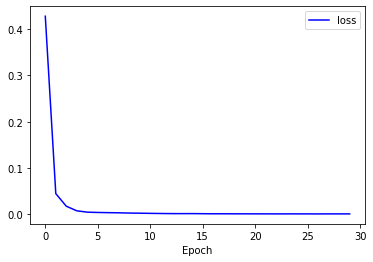

In [10]:
# 손실값 시각화
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [11]:
# test_x_array 각 샘플의 2시간 예측값이 기록되어 있는 test_pred_array shape 확인
print(test_pred_array.shape)

(529, 120, 1)


In [12]:
# 모델 저장 및 로드
model.save('./my_model.h5')
model = tf.keras.models.load_model('./my_model.h5')

In [14]:
# 매수 시점, 매수 비율 표 만들기
# 1) train_pred_array 3차원에서 2차원으로 바꾸기
pred_array_2d = np.zeros([test_pred_array.shape[0], 120])

for idx in tqdm(range(test_pred_array.shape[0])):
    pred_array_2d[idx, :] = test_pred_array[idx, :, 0]

# 2) 예측값을 재해석하여 submission 표를 작성하는 함수 정의
def array_to_submission(pred_array):
    submission = pd.DataFrame(np.zeros([pred_array.shape[0], 2], np.int64),
                              columns=['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    sell_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis=1)):
        sell_price.append(pred_array[idx, sell_time])
    sell_price = np.array(sell_price)
    submission.loc[:, 'buy_quantity'] = ((1*1*(sell_price/1)*0.9995*0.9995) > 1.08)*1 #-DACON-Bit_Trader폴더 주가 손실계산.png 참고
    submission['sell_time'] = np.argmax(pred_array, axis=1)
    submission.columns = ['sample_id', 'buy_quantity', 'sell_time']
    return submission, sell_price

final_submission, forcasted_max = array_to_submission(pred_array_2d)

100%|██████████| 529/529 [00:00<00:00, 283225.28it/s]


In [15]:
# 각 샘플의 예측치 중 최고값 모아 보기
forcasted_max

array([1.0065794 , 1.01441026, 0.93679267, 0.95263463, 0.9962129 ,
       1.04470217, 0.96156454, 0.96337712, 0.99317759, 0.98923784,
       1.0368427 , 0.96484196, 1.0166893 , 0.98878568, 0.9972856 ,
       1.02150273, 1.02592289, 0.98527056, 1.02538037, 1.02668178,
       1.01431894, 0.97106212, 1.01990569, 1.09836495, 1.02756822,
       1.10469329, 1.08048487, 0.96482199, 0.97250688, 0.98419917,
       0.9925257 , 1.02387679, 1.04667366, 0.96720475, 1.00631928,
       1.03889847, 0.97621673, 0.96684706, 1.0171299 , 1.0311259 ,
       0.92322177, 0.9835428 , 1.00146222, 1.0395757 , 0.9189626 ,
       1.01740444, 0.99568838, 1.00893879, 0.98794138, 1.03709316,
       1.03929853, 0.96503383, 1.01527643, 1.00529766, 0.98389959,
       0.96083832, 0.97983682, 0.99698496, 1.02432573, 0.99810266,
       1.11322498, 0.98820484, 1.03982139, 0.91585803, 1.00948894,
       0.96425682, 0.96712118, 0.99290192, 1.11809063, 0.97789603,
       1.00969374, 1.03134739, 1.05668056, 0.92782664, 0.98450

In [16]:
# 전체 300가지 sample에 대해 _가지 case에서 (수수료 감안해서) 매수 시점(1380분)보다 108% 이상 상승한다고 추론함.
final_submission.buy_quantity.value_counts()

False    512
True      17
Name: buy_quantity, dtype: int64

In [24]:
# (수수료 감안하지 않고) 매수 시점보다
forcasted_max[forcasted_max >= 1.08]

array([1.09836495, 1.10469329, 1.08048487, 1.11322498, 1.11809063,
       1.11189604, 1.27607596, 1.13997781, 1.10762215, 1.17250073,
       1.14777517, 1.1660763 , 1.08049989, 1.10219347, 1.17342126,
       1.08919168, 1.15119946, 1.09933197, 1.0861485 ])

In [17]:
# final_submission csv파일로 저장
final_submission.to_csv('./submission.csv', index = False)

---

In [31]:
forcasted_max = np.array([1.0065794 , 1.01441026, 0.93679267, 0.95263463, 0.9962129 ,
       1.04470217, 0.96156454, 0.96337712, 0.99317759, 0.98923784,
       1.0368427 , 0.96484196, 1.0166893 , 0.98878568, 0.9972856 ,
       1.02150273, 1.02592289, 0.98527056, 1.02538037, 1.02668178,
       1.01431894, 0.97106212, 1.01990569, 1.09836495, 1.02756822,
       1.10469329, 1.08048487, 0.96482199, 0.97250688, 0.98419917,
       0.9925257 , 1.02387679, 1.04667366, 0.96720475, 1.00631928,
       1.03889847, 0.97621673, 0.96684706, 1.0171299 , 1.0311259 ,
       0.92322177, 0.9835428 , 1.00146222, 1.0395757 , 0.9189626 ,
       1.01740444, 0.99568838, 1.00893879, 0.98794138, 1.03709316,
       1.03929853, 0.96503383, 1.01527643, 1.00529766, 0.98389959,
       0.96083832, 0.97983682, 0.99698496, 1.02432573, 0.99810266,
       1.11322498, 0.98820484, 1.03982139, 0.91585803, 1.00948894,
       0.96425682, 0.96712118, 0.99290192, 1.11809063, 0.97789603,
       1.00969374, 1.03134739, 1.05668056, 0.92782664, 0.9845044 ,
       1.00621986, 1.0416224 , 1.01342475, 0.96747202, 1.11189604,
       0.99699718, 1.06782651, 1.02171659, 0.98289645, 0.99201769,
       0.93830907, 0.94877851, 0.93801427, 0.91771084, 1.03319883,
       0.94863939, 1.01777411, 0.98115009, 0.97849214, 0.98872936,
       0.99182302, 1.02347171, 1.27607596, 1.0195961 , 0.98061615,
       1.13997781, 0.9999162 , 1.10762215, 1.02317441, 0.99676895,
       1.02686906, 0.98811936, 1.03384686, 0.98263282, 1.03438771,
       1.00222373, 0.97913915, 1.02264297, 0.97258198, 1.03133857,
       1.03502476, 0.94605422, 0.97657591, 1.05702603, 1.0154866 ,
       1.17250073, 0.97349459, 0.97367352, 1.07784235, 1.07601416,
       1.02025807, 1.03213131, 0.99918586, 0.97095579, 0.94548917,
       0.97960836, 1.00274539, 1.00798011, 0.93696493, 1.00060105,
       0.96673054, 0.96844155, 0.96408051, 1.00158787, 0.95024079,
       1.02234292, 1.04485726, 1.00018692, 0.93890339, 1.14777517,
       0.93857306, 0.99466604, 0.97476375, 1.00672567, 1.0568161 ,
       1.1660763 , 0.88703239, 0.99038076, 0.96688014, 0.95366609,
       0.90003937, 0.9770909 , 1.0229634 , 1.04560184, 0.96615678,
       0.8935414 , 1.00266254, 0.97203422, 1.00107861, 0.9718684 ,
       0.97999078, 0.96193993, 0.97848368, 1.03321898, 0.99827588,
       0.97643536, 0.93810105, 0.95938355, 0.94542319, 0.99423003,
       0.95409453, 1.02544117, 0.95914549, 1.00326693, 0.97777754,
       0.9707188 , 1.02591383, 1.03447115, 0.98033702, 1.01765978,
       0.95761555, 1.01251733, 0.98720646, 1.00226784, 1.04576361,
       0.98661673, 1.03522348, 1.02343714, 0.98901081, 0.96577662,
       0.99879533, 0.95419908, 1.02630496, 0.98549771, 1.00768209,
       1.00372422, 1.02120733, 0.99340057, 1.03806603, 0.96339053,
       0.9210785 , 0.98824489, 0.9859097 , 1.03655267, 1.03060508,
       0.99525303, 1.03708541, 0.97912896, 0.97516572, 0.96538931,
       0.97141331, 0.9920525 , 1.08049989, 0.97312886, 0.95255375,
       0.96016711, 0.94763523, 1.01296294, 1.06056917, 1.03816271,
       1.01066661, 0.95114905, 1.0177927 , 1.06653225, 0.96923971,
       1.02120328, 0.9365378 , 1.02398062, 0.98482251, 0.96432841,
       0.99984151, 0.97617221, 1.03808677, 0.99515945, 1.04617739,
       1.03970754, 1.01118255, 0.97288215, 0.9649905 , 1.04797077,
       1.04025972, 0.97705477, 0.9107464 , 0.92247373, 0.93615246,
       1.010288  , 0.96398365, 0.93465853, 0.91844207, 0.99726766,
       0.95257443, 1.0502615 , 0.94940001, 1.10219347, 0.92839134,
       1.02199888, 1.06174123, 1.04553688, 0.99459356, 1.00422931,
       0.98570293, 1.06866157, 1.04643929, 1.03694642, 0.96084201,
       0.98886162, 1.00142455, 0.96943659, 0.97481221, 1.01615286,
       0.99443656, 1.02085412, 1.03036809, 0.89826638, 0.91090339,
       1.02495694, 1.03306961, 0.97037494, 1.02033865, 0.9547053 ,
       1.00408292, 0.92122602, 1.00014377, 0.9138217 , 1.17342126,
       0.98702341, 0.97080821, 1.01818001, 1.02643812, 1.02400208,
       0.98407573, 0.98586106, 1.03314388, 0.96764559, 1.04155123,
       1.0510025 , 1.04115701, 1.00050068, 1.00013053, 0.99006903,
       0.97704297, 1.02716279, 1.08919168, 0.96974373, 0.98965448,
       0.99512869, 1.01098609, 1.05249393, 1.03907919, 0.97517997,
       0.99773848, 1.00783241, 0.99467748, 0.97996062, 0.96273106,
       0.92750388, 1.02492476, 0.92230302, 1.01267707, 1.01905107,
       1.05797386, 1.01009405, 1.01231599, 0.9776147 , 1.02381933,
       0.96404946, 0.94987875, 1.04162633, 0.93252927, 1.01455617,
       1.01413465, 1.01518691, 0.97460037, 0.96769428, 1.05115032,
       1.00932288, 0.98593336, 1.02005112, 0.995049  , 0.94258904,
       1.01796222, 0.99506086, 1.04774129, 0.99144489, 1.0356338 ,
       1.01098585, 1.07483006, 0.98593611, 1.03039372, 1.02956915,
       0.967215  , 0.99972886, 0.97976458, 0.97874039, 1.00588489,
       1.02787364, 1.00336862, 0.91790944, 1.05879676, 0.97168559,
       0.99148655, 1.03463459, 0.96508694, 0.99922377, 1.04803562,
       1.01558387, 1.02605355, 1.00572085, 0.99389392, 0.98456013,
       1.03268039, 1.00479627, 1.0208019 , 1.02020717, 1.00788879,
       1.05442953, 1.04218519, 0.99493945, 1.02787387, 0.988424  ,
       1.05971086, 1.02237535, 1.00735855, 0.96601766, 0.94491804,
       1.01114297, 1.03632009, 0.94412708, 0.99503708, 0.97809935,
       0.98321795, 0.97160083, 1.04218566, 1.04665279, 0.95321572,
       0.94863552, 1.02721131, 1.00807416, 0.96781802, 0.96433783,
       0.9284004 , 0.98689222, 1.04078221, 1.15119946, 1.02979684,
       0.97553766, 1.09933197, 1.07495248, 1.03281367, 0.96915239,
       1.04592109, 1.05572629, 1.0861485 , 0.96019322, 1.02414668,
       0.95657051, 0.95507491, 0.94674671, 0.97850597, 1.07136321,
       0.97467685, 0.97042698, 1.06747854, 1.05773056, 0.9893176 ,
       1.00414014, 1.02339673, 1.03197241, 1.00046492, 1.0214994 ,
       0.98325944, 0.98257494, 0.99025577, 0.97856146, 1.00944006,
       0.93256855, 0.98230743, 0.95875198, 1.02652252, 1.06346452,
       0.99673867, 1.06114435, 1.01973116, 0.92666554, 1.0254364 ,
       0.99466819, 1.07786548, 0.99847555, 0.99067497, 1.06686962,
       0.97913909, 0.9859103 , 1.05641925, 0.94291908, 0.99300295,
       1.0311029 , 1.00482225, 0.96212506, 1.05377471, 0.99549294,
       1.0022341 , 1.07437372, 1.00378513, 1.03888071, 0.9665693 ,
       1.04088521, 0.93599629, 1.04600418, 0.97741258, 1.04731905,
       0.95125884, 0.93689406, 0.98672026, 0.98503309, 1.00422812,
       0.94472957, 0.97476602, 1.02272463, 0.94372642, 1.00191963,
       0.99464881, 0.9948234 , 1.01057267, 0.9933421 , 0.98892772,
       0.96496403, 1.01080871, 0.92618644, 0.94617021, 1.01859796,
       1.04663002, 1.00299931, 1.03730428, 0.98753816, 0.98874718,
       0.99014807, 0.96099061, 0.971973  , 0.99697995, 1.00956547,
       1.02836859, 1.0232929 , 1.01373661, 0.94604689, 0.98887771,
       0.98924828, 0.99897289, 0.94501275, 0.9566682 , 1.01734698,
       1.01776481, 0.97679836, 1.04253197, 1.00672615, 1.04028904,
       0.96025473, 1.05315185, 0.97637963, 1.03204584, 0.94754422,
       1.0106324 , 1.00989068, 0.99018216, 0.99898666])

In [32]:
len(forcasted_max)

529

In [42]:
l = []
for i in forcasted_max[forcasted_max>=1.13]:
    l.append(i)
l

[1.27607596,
 1.13997781,
 1.17250073,
 1.14777517,
 1.1660763,
 1.17342126,
 1.15119946]

In [43]:
for j in l:
    print(np.where(forcasted_max == j))

(array([97], dtype=int64),)
(array([100], dtype=int64),)
(array([120], dtype=int64),)
(array([144], dtype=int64),)
(array([150], dtype=int64),)
(array([289], dtype=int64),)
(array([408], dtype=int64),)


In [11]:
# 모델 평가: test_x데이터로 예측하는 방식을 입력값(train_x)에 대한 예측값과 실제값(train_y_array) 비교를 통해 평가

train_pred_array = np.zeros([1, 120, 1])

sample = 70  #평가용 임의의 샘플 id

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10, mode = 'auto')
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience= 3, min_lr = 0)

# train_x_array데이터로 시계열 Windows 만들기
# idx에 해당하는 샘플 하나만 학습하므로 for loop는 한 번만 돌아감
ep = 30
bs = 120
for idx in range(sample, sample+1):
    seq_len = 60  # window_size와 같은 개념
    sequence_length = seq_len + 1

    windows = []
    for index in range(1380 - sequence_length):
        windows.append(train_x_array[idx, :, 1][index: index + sequence_length])

    # x_train, y_train 데이터 구성
    windows = np.array(windows) #1329 * 121의 2차원 배열
    x_train = windows[:, :-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    y_train = windows[:, -1]

    
    # Fit(early_stoppage & reduceLR 적용)
    model = build_model()
    history = model.fit(x_train, y_train, validation_split=0.1, epochs = ep, batch_size = bs, verbose = 2, callbacks = [early_stop, reduceLR])
    print('sample_id : ', idx, '번')
    print('loss : ', history.history['loss'][-1])
#     print('mse : ', history.history['mse'][-1])  #<- model.compile()의 metrics인자값으로 설정된 값을 추가로 출력해 주고 싶다면!
    print('lr : ', round(model.optimizer.lr.numpy(), 5))  #<-조정된 학습률 출력
    
    # train_x_array Windows 중 마지막 윈도우 추출해서 3차원 변환시켜 LSTM모델에 넣고 Predict
    window = windows[-1, :-1]
    window_3d = np.reshape(window, (1, window.shape[0], 1))
    for m in range(120):
        # model.predict()에 window_3d 넣어 예측
        pred = model.predict(window_3d)

        # 120분 중 처음 1분 예측값 train_pred_array에 기록
        train_pred_array[:, m, :] = pred

        # window_3d의 첫번째 분 값은 삭제한 window_3d_2nd 구성
        window_3d_2nd = window_3d[0, 1:, :]  # 119개

        # pred_target(prediction할 때마다 나오는 각각의 예측값들) 1차원 -> 2차원으로 구성
        pred_target = train_pred_array[:, m, :]
        pred_target = np.reshape(pred_target, (pred_target.shape[0], 1))

        # train_pred_array와 window_3d_2nd 병합하여 모델에 입력할 새로운 window_3d 재구성
        window_3d = np.concatenate((window_3d_2nd, pred_target), axis=0)
        window_3d = window_3d.T
        window_3d = np.reshape(window_3d, (window_3d.shape[0], window_3d.shape[1], 1))

Train on 1187 samples, validate on 132 samples
Epoch 1/30
1187/1187 - 4s - loss: 0.3678 - mse: 0.3678 - val_loss: 0.0821 - val_mse: 0.0821
Epoch 2/30
1187/1187 - 0s - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 3/30
1187/1187 - 0s - loss: 0.0206 - mse: 0.0206 - val_loss: 9.7687e-05 - val_mse: 9.7687e-05
Epoch 4/30
1187/1187 - 0s - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 5/30
1187/1187 - 0s - loss: 0.0059 - mse: 0.0059 - val_loss: 9.4600e-04 - val_mse: 9.4600e-04
Epoch 6/30
1187/1187 - 0s - loss: 0.0045 - mse: 0.0045 - val_loss: 8.1144e-04 - val_mse: 8.1144e-04
Epoch 7/30
1187/1187 - 0s - loss: 0.0039 - mse: 0.0039 - val_loss: 4.9652e-04 - val_mse: 4.9652e-04
Epoch 8/30
1187/1187 - 0s - loss: 0.0037 - mse: 0.0037 - val_loss: 1.2527e-04 - val_mse: 1.2527e-04
Epoch 9/30
1187/1187 - 0s - loss: 0.0036 - mse: 0.0036 - val_loss: 1.6460e-05 - val_mse: 1.6460e-05
Epoch 10/30
1187/1187 - 0s - loss: 0.0035 - mse: 0.0035 - val_loss: 1.4253e-0

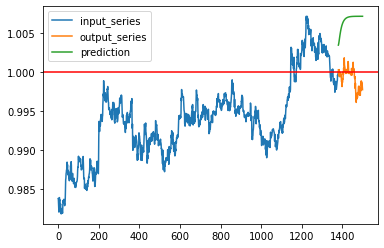

In [12]:
# train 샘플 훈련 성과 시각화해보기
# 1) 입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 정의
def plot_series(x_series, y_series):
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

# 2) train data 중 sample_id idx에 해당하는 x_series로 모델을 학습한 후 y_series를 추론
x_series = train_x_array[sample,:,1]
y_series = train_y_array[sample,:,1]
plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), train_pred_array[0,:,0], label = 'prediction')
plt.legend()
plt.show()

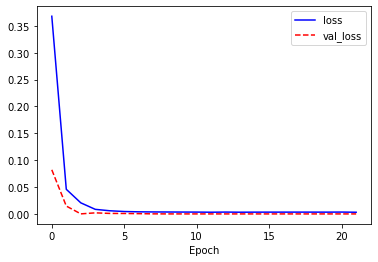

In [13]:
# 손실값 시각화
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

---

In [ ]:
# train_x_df의 자료들을 학습에 활용하게 될 경우:
# train_x_df를 sample_id을 기준으로 추출하는 방법
train_x_df = train_x_df[train_x_df.sample_id < 300]
train_y_df = train_y_df[train_y_df.sample_id < 300]